## Table of Contents
* [1. Prepare data and get ready for modelling](#A1)
* [2. Generalized Linear Models (GLM)](#A2)
* [3. Model champions: Gradient tree boosting machines](#A3)
* [4. Deep Learning Approach with Embeddings and the "CANN"](#A4)
* [5. Summary and Outlook](#A5)
<br>
<a id="A"></a>

<a id="A1"></a>
## 1. Prepare data and get ready for modelling

<img src="https://i.postimg.cc/d13q5ywF/TF-DALL-E-2023-10-24-23-43-07-Photorealistic-wide-format-illustration-inside-a-modern-sophisticat.png" style="float: center; width: '100%'; max-width: '800px'">

### 1.1 Import required libraries and set device-parameters (cpu/gpu)

In [1]:
import os
# Set environment variable to ignore all warnings
os.environ['PYTHONWARNINGS'] = 'ignore'

seed= 123 # 2023 # 42 # for reproducible random numbers
%matplotlib inline
%config InlineBackend.figure_format = 'png'
#%config InlineBackend.figure_format = 'svg'

import locale
locale.setlocale(locale.LC_ALL, "")

import subprocess
import time
import random

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy.stats import uniform, loguniform
#!pip install pyarrow_hotfix # due to PyArrow security vulnerability 
#import pyarrow_hotfix

# Explainable AI methods
import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG, Image

sns.set(rc={'figure.figsize':(12,7)})
sns.set_theme()

# Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
#egyelőre nem lassítom vele
#!pip install pytorch-tabnet
#from pytorch_tabnet.tab_model import TabNetRegressor


# Tuning #This should be realized a transparent and visualized way
from sklearn.model_selection import GridSearchCV

In [2]:
# Set device-parameters cpu/gpu according to the selected accelerator (Kaggle notebook option):

device_LGB = 'cpu'
device_XGB = 'cpu'

# Execute the nvidia-smi command to check for NVIDIA GPUs
try:
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode == 0 and 'NVIDIA' in result.stdout:
        device_LGB = 'gpu'
        device_XGB = 'cuda'
        print("NVIDIA GPU is available and supports LightGBM, XGBoost and TensorFlow")
    else:
         print("NVIDIA GPU is not available.")
except FileNotFoundError:
    print("nvidia-smi command not found (i.e. NVIDIA GPU is not selected, see notebook options).")

nvidia-smi command not found (i.e. NVIDIA GPU is not selected, see notebook options).


### 1.2 Read dataset and correct claim number 

We analyse data for motor third party liability claims (MTPL) in France. The data is available via the R library CASdatasets by Christophe Dutang. The specific datasets are called FreMTPL2freq and FreMTPL2sev. The former contains the information on the insurance policy and claims frequency and the latter the corresponding information on claims severity.

The claim counts on the insurance policies with policy IDs ≤ 24500 in the dataset FreMTPL2freq do not have claim severity counterparts in the dataset FreMTPL2sev and thus seem not to be correct. For this reason we work with the claim counts extracted from FreMTPL2sev. More details can be found here (https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev) and in Chapter 13.1 of "Statistical Foundations of Actuarial Learning and its Applications" by Mario Wüthrich and Michael Merz (open access book, 2023).

In [3]:
# read frequency data
df_raw = pd.read_csv("../input/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv")
df_raw.IDpol = df_raw.IDpol.astype(int) # policy ID should be integer

# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
# see below cells
df_raw["ClaimNb"] = np.minimum(4, df_raw.ClaimNb)
df_raw["ClaimFreq"]=df_raw["ClaimNb"]/df_raw["Exposure"]

# import folds from the linked R notebook (to obtain the same subsamples and reproduce some results)
df_folds = pd.read_csv("../input/fremtpl2freq-folds/freMTPL2freq_folds.csv")
df_folds.IDpol = df_folds.IDpol.astype(int) # policy ID should be integer
df = pd.merge(df_raw, df_folds, how='inner', on='IDpol')

print("\nNumber of data rows and columns: ", df.shape)
print("\nCheck the end of the data set (possibly corrupted data):")
df.tail(6) # view end of dataset


Number of data rows and columns:  (678013, 14)

Check the end of the data set (possibly corrupted data):


IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
678007  6114325        0  0.005479    E         6       4       40   
678008  6114326        0  0.002740    E         4       0       54   
678009  6114327        0  0.002740    E         4       0       41   
678010  6114328        0  0.002740    D         6       2       45   
678011  6114329        0  0.002740    B         4       0       60   
678012  6114330        0  0.002740    B         7       6       29   

        BonusMalus VehBrand   VehGas  Density Region  ClaimFreq  fold  
678007          68      B12  Regular     2733    R93        0.0     2  
678008          50      B12  Regular     3317    R93        0.0     3  
678009          95      B12  Regular     9850    R11        0.0     5  
678010          50      B12   Diesel     1323    R82        0.0     5  
678011          50      B12  Regular       95    R26        0.0     3  
678012          54      B12   Diesel       65    R72        0.0     5

Exposure >1 must be error, correction is OK

In [4]:
NaN_counts=df.isna().sum().to_frame().T
NaN_counts.index = ['NaNs']
unique_counts = df.nunique().to_frame().T
unique_counts.index = ['unique']
pd.concat([df.describe(),NaN_counts,unique_counts])

IDpol        ClaimNb       Exposure       VehPower  \
count   6.780130e+05  678013.000000  678013.000000  678013.000000   
mean    2.621857e+06       0.053179       0.528750       6.454631   
std     1.641783e+06       0.237954       0.364442       2.050906   
min     1.000000e+00       0.000000       0.002732       4.000000   
25%     1.157951e+06       0.000000       0.180000       5.000000   
50%     2.272152e+06       0.000000       0.490000       6.000000   
75%     4.046274e+06       0.000000       0.990000       7.000000   
max     6.114330e+06       4.000000       2.010000      15.000000   
NaNs    0.000000e+00       0.000000       0.000000       0.000000   
unique  6.780130e+05       5.000000     187.000000      12.000000   

               VehAge        DrivAge     BonusMalus        Density  \
count   678013.000000  678013.000000  678013.000000  678013.000000   
mean         7.044265      45.499122      59.761502    1792.422405   
std          5.666232      14.137444      15.636658    3958.646564   
min          0.000000      18.000000      50.000000       1.000000   
25%          2.000000      34.000000      50.000000      92.000000   
50%          6.000000      44.000000      50.000000     393.000000   
75%         11.000000      55.000000      64.000000    1658.000000   
max        100.000000     100.000000     230.000000   27000.000000   
NaNs         0.000000       0.000000       0.000000       0.000000   
unique      78.000000      83.000000     115.000000    1607.000000   

            ClaimFreq           fold  Area  VehBrand  VehGas  Region  
count   678013.000000  678013.000000   NaN       NaN     NaN     NaN  
mean         0.263488       2.997021   NaN       NaN     NaN     NaN  
std          4.585558       1.413916   NaN       NaN     NaN     NaN  
min          0.000000       1.000000   NaN       NaN     NaN     NaN  
25%          0.000000       2.000000   NaN       NaN     NaN     NaN  
50%          0.000000       3.000000   NaN       NaN     NaN     NaN  
75%          0.000000       4.000000   NaN       NaN     NaN     NaN  
max        732.000000       5.000000   NaN       NaN     NaN     NaN  
NaNs         0.000000       0.000000   0.0       0.0     0.0     0.0  
unique     236.000000       5.000000   6.0      11.0     2.0    22.0

Check data types

In [5]:
df.dtypes

IDpol           int64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
ClaimFreq     float64
fold            int64
dtype: object

Fitting GLM

RecommendBandingFunc uses the result pandas database (in plot1way funtion) checks whether GroupByCol is numeric and if so then processes the values of GroupByCol in ascending order and fills a binning list. Therefore result is sorted by GroupByCol. The first value (call the index vairable i, so for i==1) always gets in the list. The last value in the binning list called b. After that check if the next value is significantly different from the last in the binning list. In details: result.loc[i,'V'] is between result.loc[b,'lowerSE'] and result.loc[b,'upperSE']. After that check also that if result.loc[b,'V'] between result.loc[i,'lowerSE'] and result.loc[i,'upperSE']. If any of that two condition met than i is omitted from the list, and i can be increased. If none of the two condition met than i is included to the list and both i and b increased

In [6]:
def RecommendBandingFunc(result, GroupByCol):
    # Initialize binning list
    binning_list = []

    for i in range(len(result)):
        current_row = result.loc[i]
        # Always include the first value
        if i != 0 and ((last_binned_rowSE_Lower <= current_row['V'] <= last_binned_rowSE_Upper) or \
                       (current_row['SE_Lower'] <= last_binned_rowV <= current_row['SE_Upper'])):
            pass
        else:
            # If none of the conditions are met, include i
            binning_list.append(current_row[GroupByCol])
            last_binned_rowV=current_row['V']
            last_binned_rowSE_Lower=current_row['SE_Lower']
            last_binned_rowSE_Upper=current_row['SE_Upper']
    return(binning_list)


In [7]:
def plot1way(df, GroupByCol, WeightCol, ValueCol, PrintTable=None, nbins=None, lower=None, upper=None
             ,show2SE=True, resetXaxis=False, polinomDegree=None, recommendBanding=False, silent=False
            ,sortby=None):
    """
    Plot the sum of Exposure and the Claim frequency and Claim frequency +/-2 Standard Error.

    Parameters:
    - df: pandas DataFrame
    - GroupByCol: str, column name for vehicle power
    - WeightCol: str, column name for exposure
    - ValueCol: str, column name for claim frequency
    """
    # Group by GroupByCol and aggregate
    result=df.copy()
    if lower is not None:
        result[GroupByCol]=np.maximum(lower, result[GroupByCol])
    if upper is not None:
        result[GroupByCol]=np.minimum(upper, result[GroupByCol])
    if nbins is not None:
        #print(pd.Series(result['bins'].unique()).sort_values().reset_index(drop=True))
        result['bins']=pd.qcut(result[GroupByCol], q=nbins, duplicates='drop')
        result['ori']=result[GroupByCol]
        result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')
        #print(result.drop_duplicates(subset=['ori',GroupByCol,'bins']).sort_values(by='ori').reset_index(drop=True))
        #print(result)
        #result[GroupByCol]=result[GroupByCol].groupby(bins).min()
    
    result = result.groupby(GroupByCol).agg(
        W=(WeightCol, 'sum'),
        V=(ValueCol, 'mean'),
        Std=(ValueCol, 'std')
    ).reset_index()
    
    # Calculate Standard Error
    result['SE_Lower']=result['V']-2*result["Std"]/np.sqrt(result['W'])
    result['SE_Upper']=result['V']+2*result["Std"]/np.sqrt(result['W'])
    
    # Sorting
    if sortby is None:
        sortby=GroupByCol
    result = result.sort_values(by=sortby).reset_index(drop=True)

        
    # Optinally recommend binning, using upper, lower and nbins, before of optional resetXaxis
    if recommendBanding:
        binning_df=RecommendBandingFunc(result, GroupByCol)
    
    if not silent:
        if resetXaxis:
            result['value']=result[GroupByCol]
            result[GroupByCol]=result[GroupByCol].rank(method='dense', ascending=True)

        # Plotting
        fig, ax1 = plt.subplots()

        # Bar chart for the sum of Exposure
        ax1.bar(result[GroupByCol], result['W'], color='b', alpha=0.6, label='Exposure')
        ax1.set_xlabel(GroupByCol)
        ax1.set_ylabel('Exposure', color='b')

        # Create a second y-axis for the line chart
        ax2 = ax1.twinx()
        ax2.plot(result[GroupByCol], result['V'], color='r', marker='o', label='Claim Frequency')
        ax2.set_ylabel('Claim Frequency', color='r')

        # Optionally plot +/- 2× Standard Error
        if show2SE:
            ax2.fill_between(result[GroupByCol], result['SE_Lower'], result['SE_Upper'], color='r', alpha=0.2, label='±2 Standard Error')

        # Optinally fit polinom (if ResetXaxis then on 1,2,3,... otherwise on actual numbers)
        if polinomDegree is not None:
            coefficients = np.polyfit(result[GroupByCol], result['V'], polinomDegree, w=result['W'])
            polynomial = np.poly1d(coefficients)
            y_fit = polynomial(result[GroupByCol])
            ax2.plot(result[GroupByCol], y_fit, color='g', label='Fitted')



        fig.suptitle('Exposure and Claim Frequency by ' + GroupByCol)

        # Add legends
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.show()

        # Optionally Print Table in shortened or full view
        if PrintTable==1:
            print(result)
        if PrintTable==2:
            print(result.to_string(index=False))

        # Printing if banding recommendation requested
        if recommendBanding:
            print(binning_df)
    elif recommendBanding:
        return(binning_df)

In [8]:
def applyBanding(value, banding_values):
    # Find the greatest value in banding_values that is not greater than value
    bandedValue = max((b for b in banding_values if b <= value), default=min(banding_values))
    return bandedValue

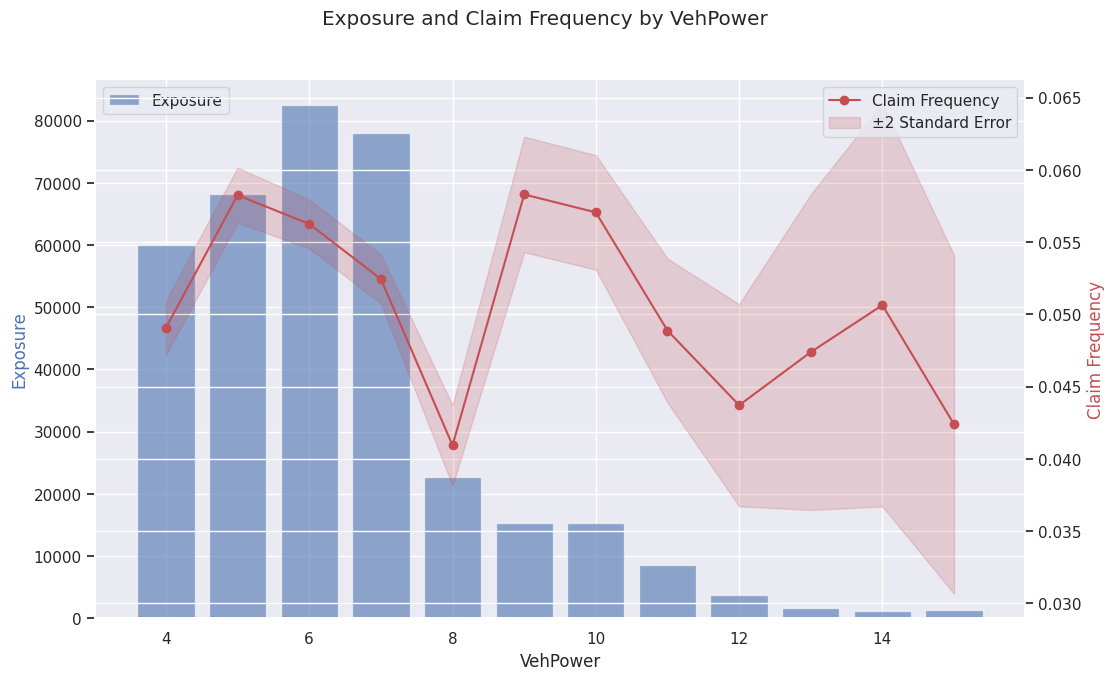

[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0]


In [9]:
plot1way(df, 'VehPower', 'Exposure', 'ClaimNb', recommendBanding=True)

Recommended banding is OK. We'll apply it (processed variable will start with _) and check it back on the chart

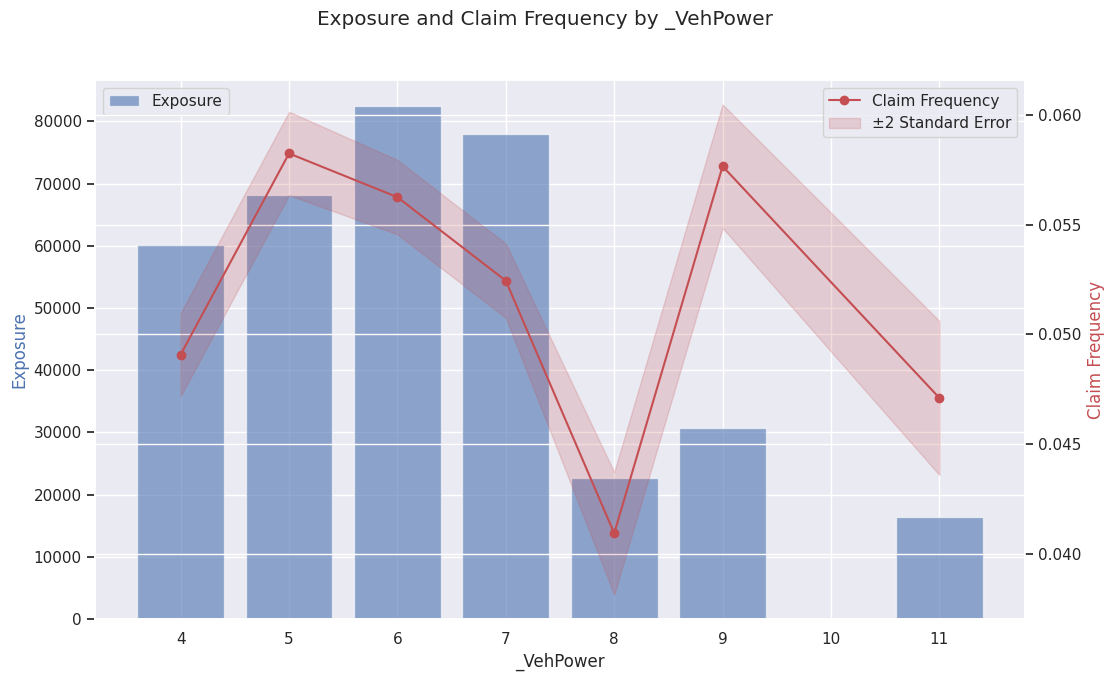

[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0]


In [10]:
banding={'VehPower':[4,5,6,7,8,9,11]}
df['_VehPower'] = df['VehPower'].apply(applyBanding, banding_values=banding['VehPower'])
plot1way(df, '_VehPower', 'Exposure', 'ClaimNb', recommendBanding=True)

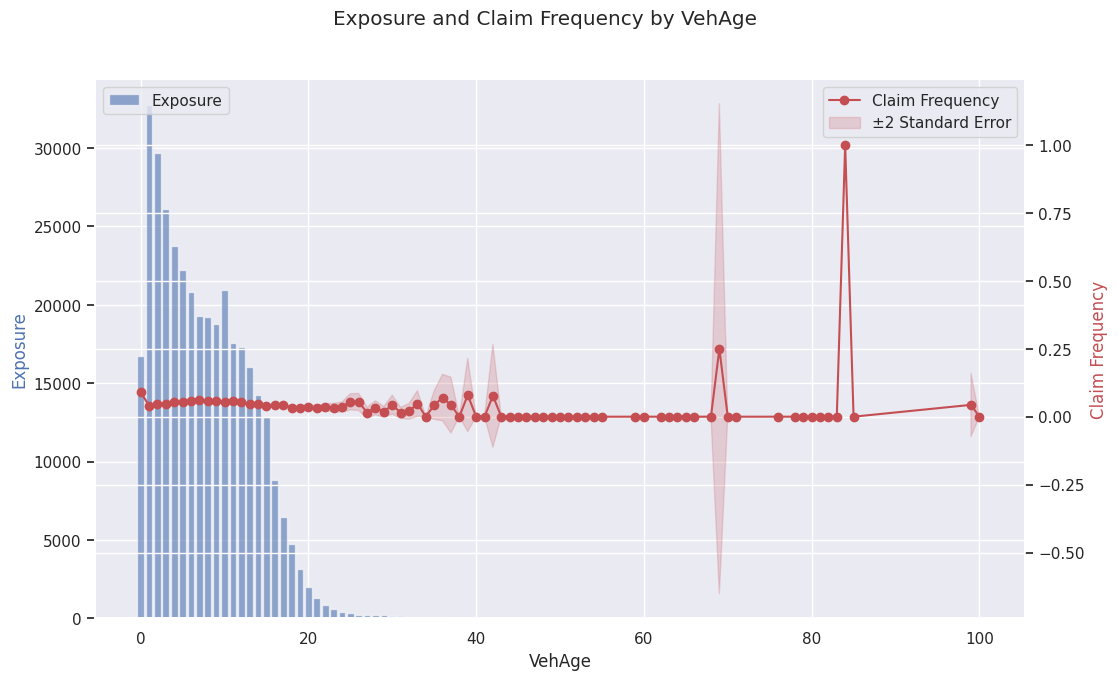

In [11]:
plot1way(df, 'VehAge', 'Exposure', 'ClaimNb')

The above chart is clearly not something like we want to use natively.
Vehicles 25 or more years old could be grouped together

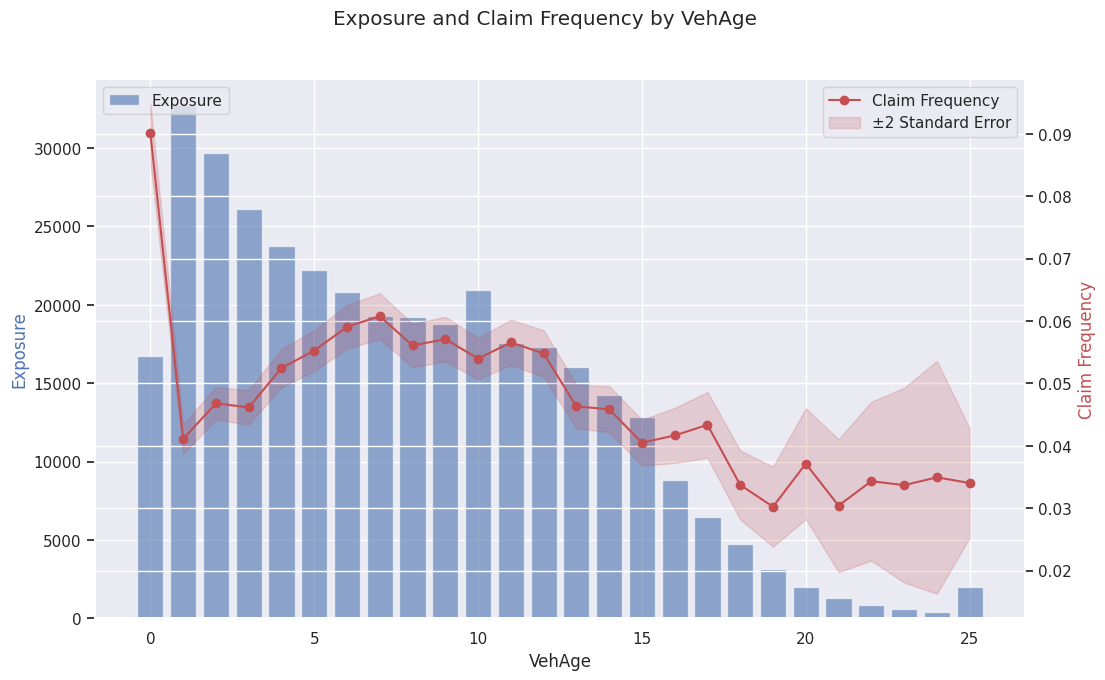

[0.0, 1.0, 2.0, 4.0, 6.0, 10.0, 13.0, 15.0, 18.0]


In [12]:
plot1way(df, 'VehAge', 'Exposure', 'ClaimNb', upper=25, recommendBanding=True)

#RecommendedBanding is OK, we'll aplly that
As an expert judgement, we assignt 8,9 from 6 to 10
The reason behind that decision is 10 is a bit outlies from the constant 8..11, while 3..9 is rather like increasing

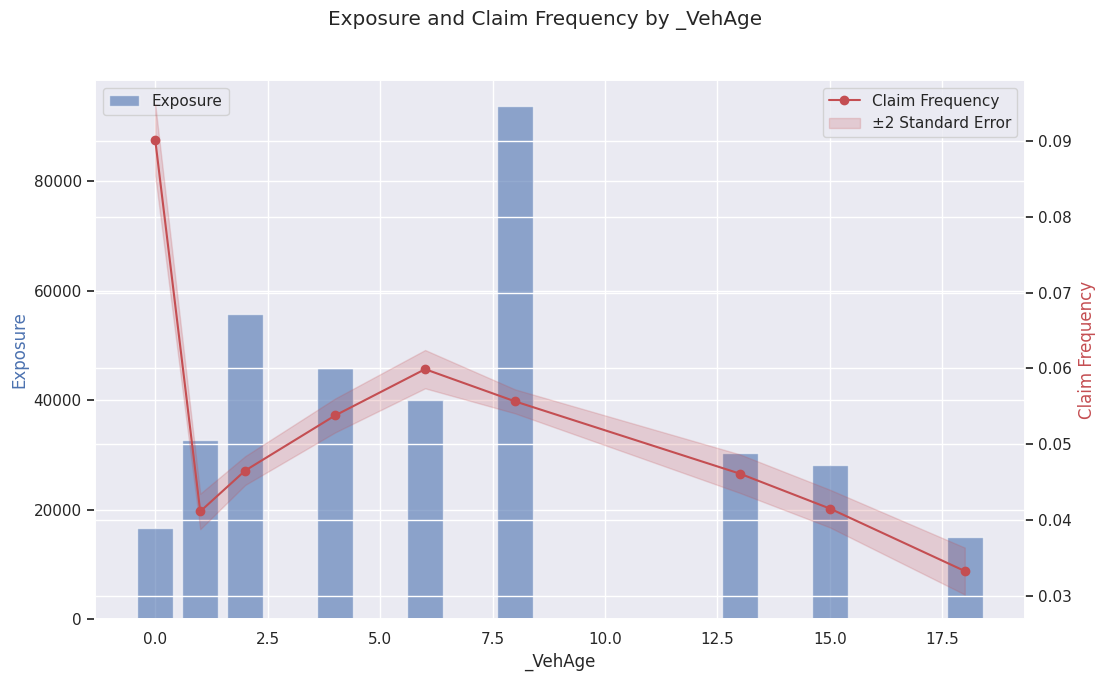

[0.0, 1.0, 2.0, 4.0, 6.0, 8.0, 13.0, 15.0, 18.0]


In [13]:
banding={'VehAge':[0,1,2,4,6,8,13,15,18]}
df['_VehAge'] = df['VehAge'].apply(applyBanding, banding_values=banding['VehAge'])
plot1way(df, '_VehAge', 'Exposure', 'ClaimNb', recommendBanding=True)

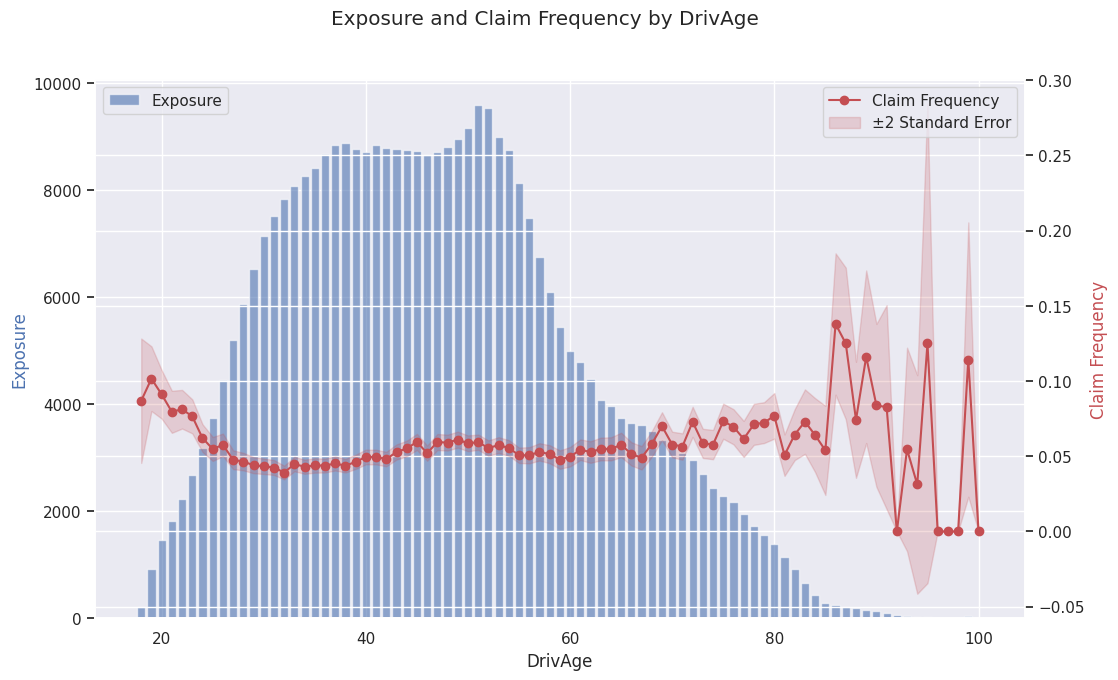

 DrivAge           W        V      Std  SE_Lower  SE_Upper
      18  210.709377 0.086898 0.300271  0.045527  0.128270
      19  912.894303 0.101589 0.324848  0.080086  0.123092
      20 1460.979158 0.091132 0.307932  0.075019  0.107244
      21 1820.101138 0.079558 0.298371  0.065571  0.093546
      22 2223.703357 0.081270 0.302808  0.068427  0.094113
      23 2672.610001 0.076505 0.292711  0.065181  0.087829
      24 3188.163750 0.062086 0.259167  0.052906  0.071266
      25 3738.742178 0.054846 0.243319  0.046888  0.062805
      26 4456.240507 0.057567 0.250604  0.050059  0.065075
      27 5199.718572 0.047687 0.225078  0.041445  0.053930
      28 5861.494624 0.046442 0.223152  0.040613  0.052272
      29 6529.064699 0.044067 0.216658  0.038704  0.049430
      30 7133.715418 0.043335 0.216530  0.038208  0.048462
      31 7519.763279 0.042517 0.214957  0.037560  0.047475
      32 7821.267161 0.039167 0.201878  0.034602  0.043733
      33 8079.402838 0.044831 0.215891  0.040027  0.0496

In [14]:
plot1way(df, 'DrivAge', 'Exposure', 'ClaimNb', PrintTable=2)

Due to large standard error at <=23 and >=72 we should try a mild binning first

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


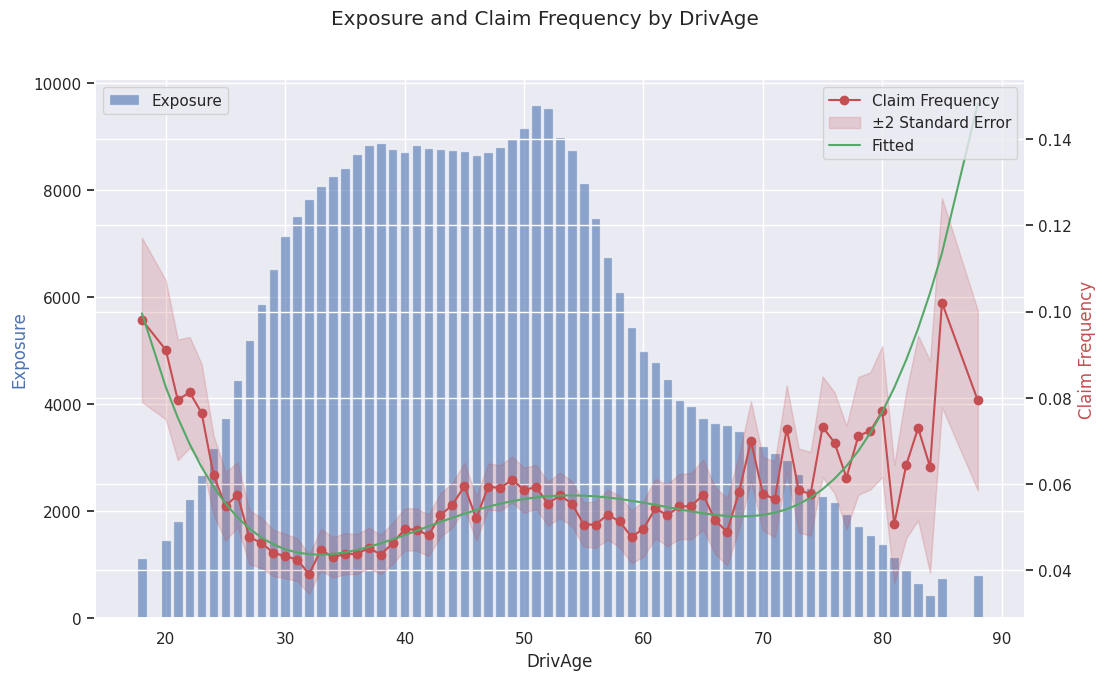

In [15]:
plot1way(df, 'DrivAge', 'Exposure', 'ClaimNb', nbins=678, polinomDegree=4)

Above 65 and below 23 years there may be too few observations/age. Try to bin it more aggressive (with smaller nbins)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


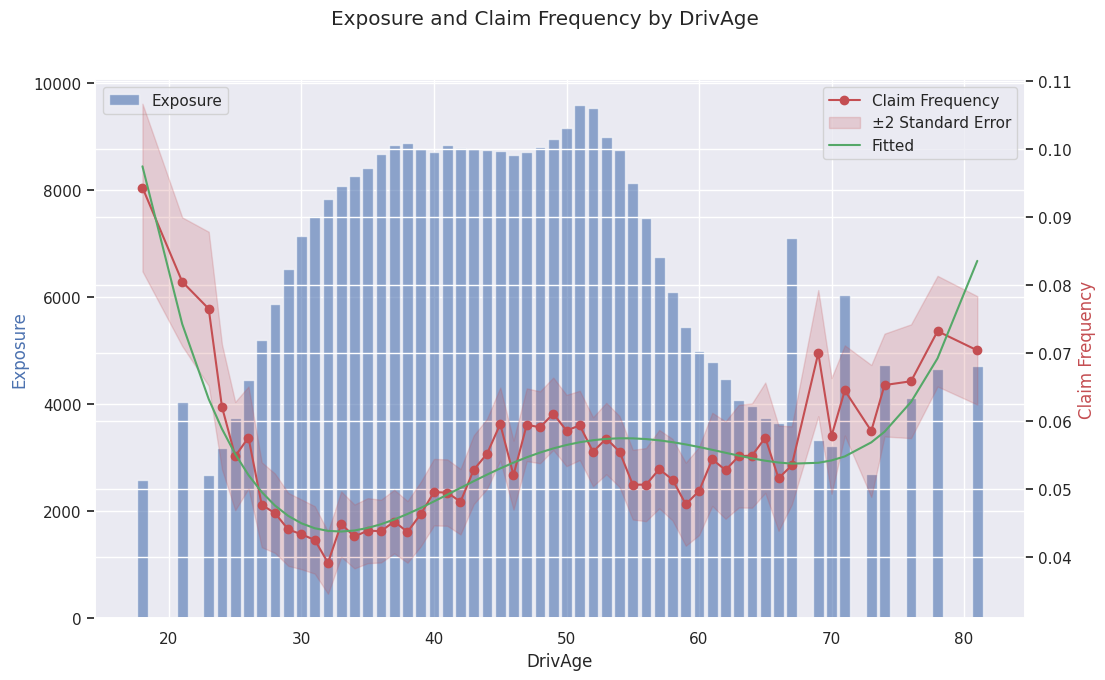

In [16]:
plot1way(df, 'DrivAge', 'Exposure', 'ClaimNb', nbins=100, polinomDegree=4)

Still to small bins in the edges, nbins decreased furter
also, 6th degree polynom fits the +/-2 Standard Error Range better

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


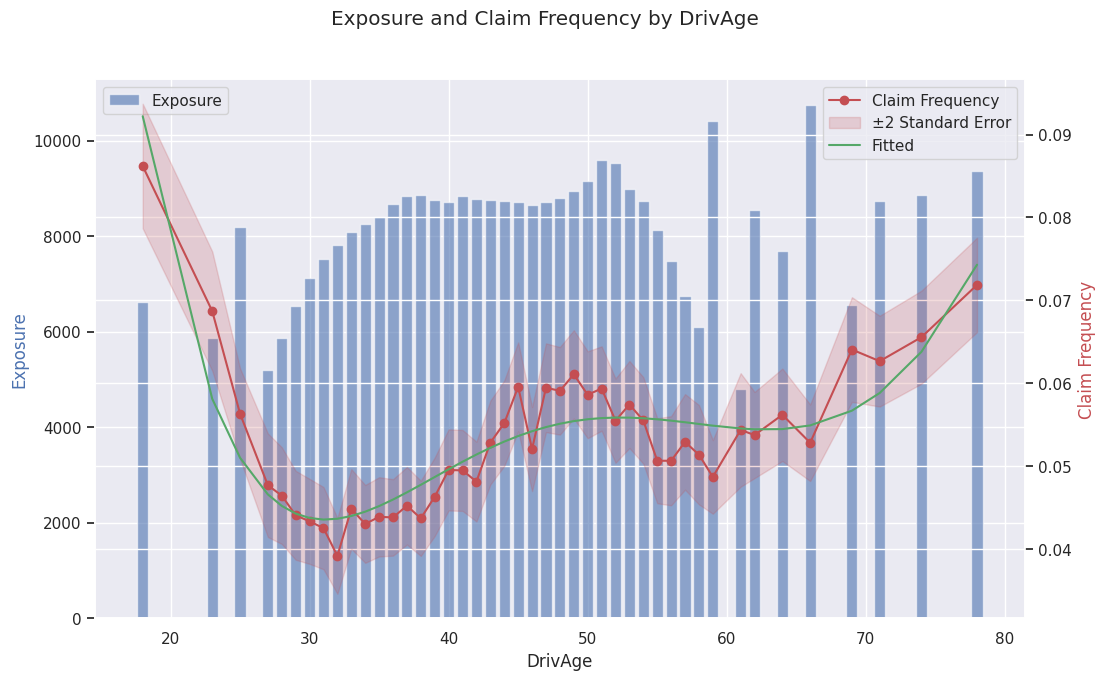

[18.0, 23.0, 25.0, 27.0, 32.0, 33.0, 43.0, 45.0, 46.0, 47.0, 55.0, 69.0, 78.0]


In [17]:
plot1way(df, 'DrivAge', 'Exposure', 'ClaimNb', nbins=50, polinomDegree=5, recommendBanding=True)

Despite of using polinom, banding should be still used.
At the edges the 5th degree produces extreme values (see below), also lower exposures outside of the middle (but still not in the edges) would produce higher errors

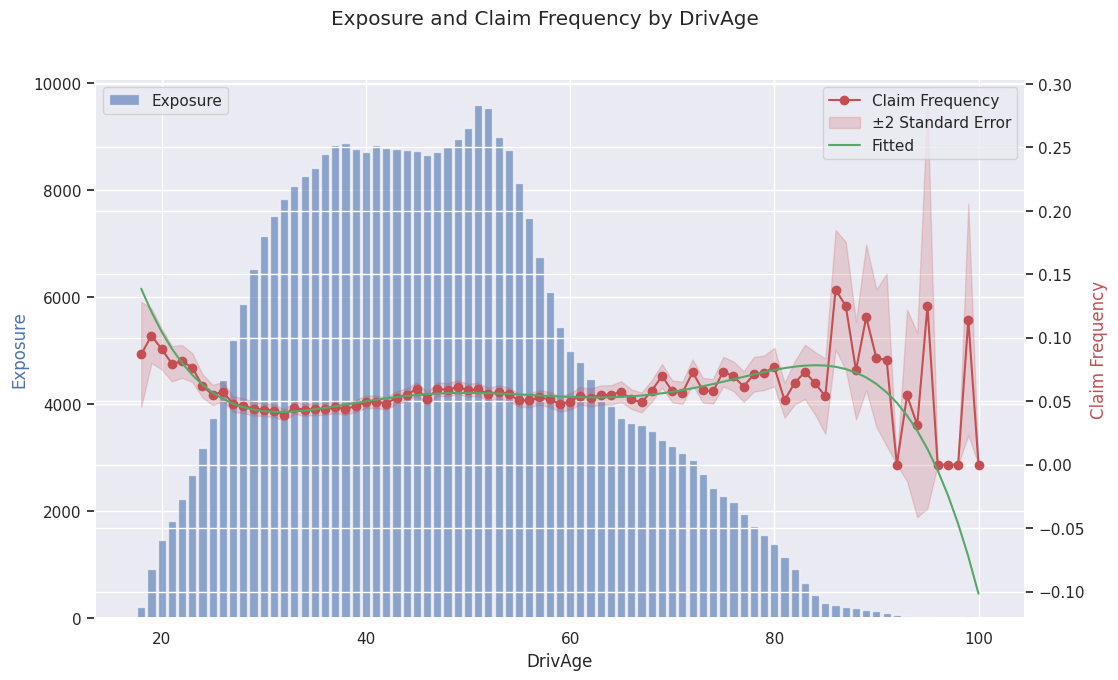

In [18]:
plot1way(df, 'DrivAge', 'Exposure', 'ClaimNb', polinomDegree=5)

To get the prebanding before 5th degree fit easily, we'll copy the values get from full (2) printTable

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


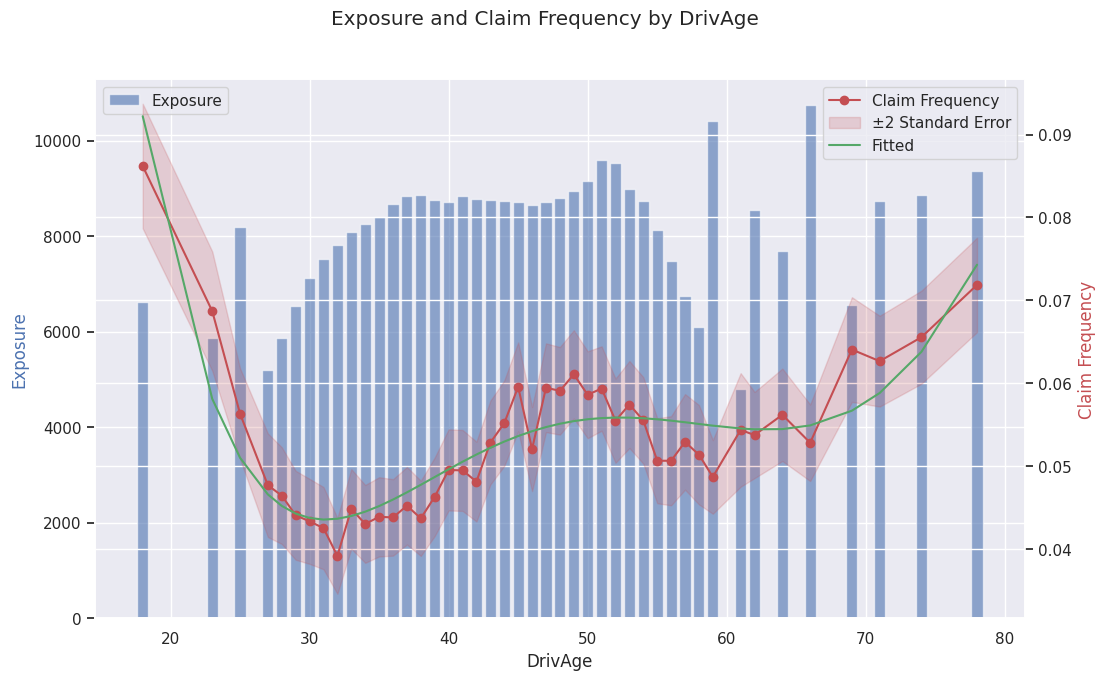

 DrivAge            W        V      Std  SE_Lower  SE_Upper
      18  6628.387333 0.086194 0.306007  0.078677  0.093712
      23  5860.773752 0.068698 0.275140  0.061510  0.075886
      25  8194.982685 0.056322 0.247293  0.050858  0.061785
      27  5199.718572 0.047687 0.225078  0.041445  0.053930
      28  5861.494624 0.046442 0.223152  0.040613  0.052272
      29  6529.064699 0.044067 0.216658  0.038704  0.049430
      30  7133.715418 0.043335 0.216530  0.038208  0.048462
      31  7519.763279 0.042517 0.214957  0.037560  0.047475
      32  7821.267161 0.039167 0.201878  0.034602  0.043733
      33  8079.402838 0.044831 0.215891  0.040027  0.049635
      34  8259.205161 0.043027 0.213346  0.038332  0.047722
      35  8406.905817 0.043879 0.219043  0.039101  0.048657
      36  8672.491160 0.043811 0.214745  0.039199  0.048423
      37  8833.389381 0.045215 0.219686  0.040541  0.049890
      38  8871.820665 0.043699 0.213534  0.039165  0.048233
      39  8760.167585 0.046305 0.221650 

In [19]:
plot1way(df, 'DrivAge', 'Exposure', 'ClaimNb', nbins=50, polinomDegree=5, PrintTable=2)

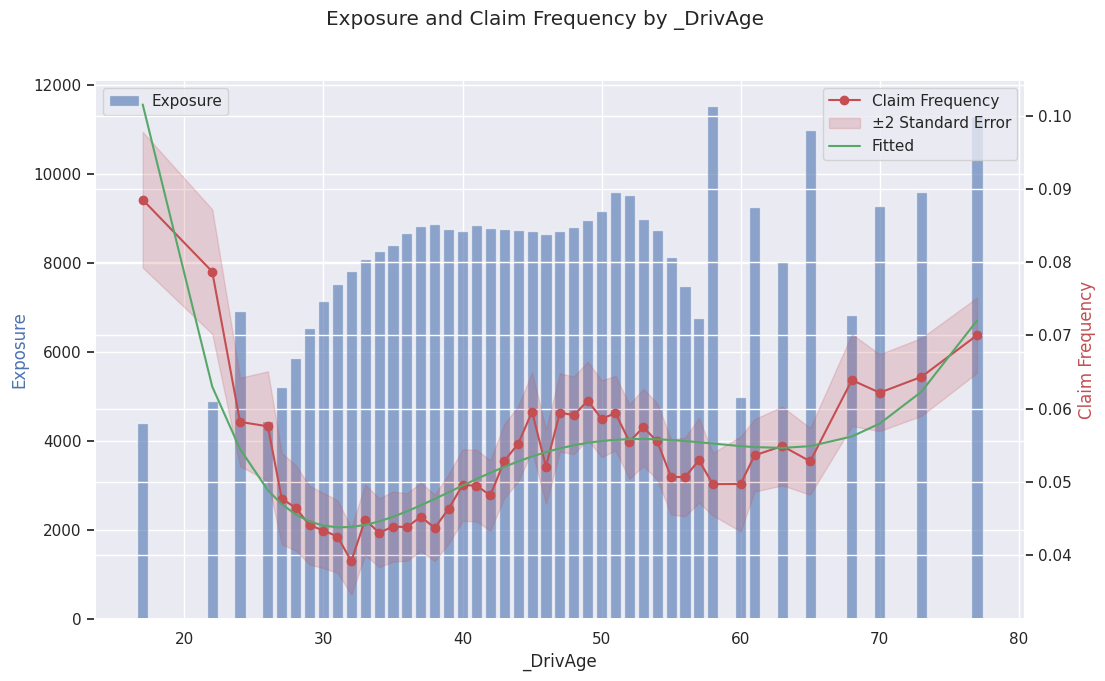

 _DrivAge            W        V      Std  SE_Lower  SE_Upper
       17  4404.683976 0.088510 0.307485  0.079244  0.097776
       22  4896.313358 0.078688 0.297374  0.070188  0.087187
       24  6926.905929 0.058173 0.250743  0.052147  0.064198
       26  4456.240507 0.057567 0.250604  0.050059  0.065075
       27  5199.718572 0.047687 0.225078  0.041445  0.053930
       28  5861.494624 0.046442 0.223152  0.040613  0.052272
       29  6529.064699 0.044067 0.216658  0.038704  0.049430
       30  7133.715418 0.043335 0.216530  0.038208  0.048462
       31  7519.763279 0.042517 0.214957  0.037560  0.047475
       32  7821.267161 0.039167 0.201878  0.034602  0.043733
       33  8079.402838 0.044831 0.215891  0.040027  0.049635
       34  8259.205161 0.043027 0.213346  0.038332  0.047722
       35  8406.905817 0.043879 0.219043  0.039101  0.048657
       36  8672.491160 0.043811 0.214745  0.039199  0.048423
       37  8833.389381 0.045215 0.219686  0.040541  0.049890
       38  8871.820665 0

In [20]:
banding={'DrivAge':[17,22,24,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,63,65,68,70,73,77]}
df['_DrivAge'] = df['DrivAge'].apply(applyBanding, banding_values=banding['DrivAge'])
plot1way(df, '_DrivAge', 'Exposure', 'ClaimNb', polinomDegree=5, PrintTable=2)

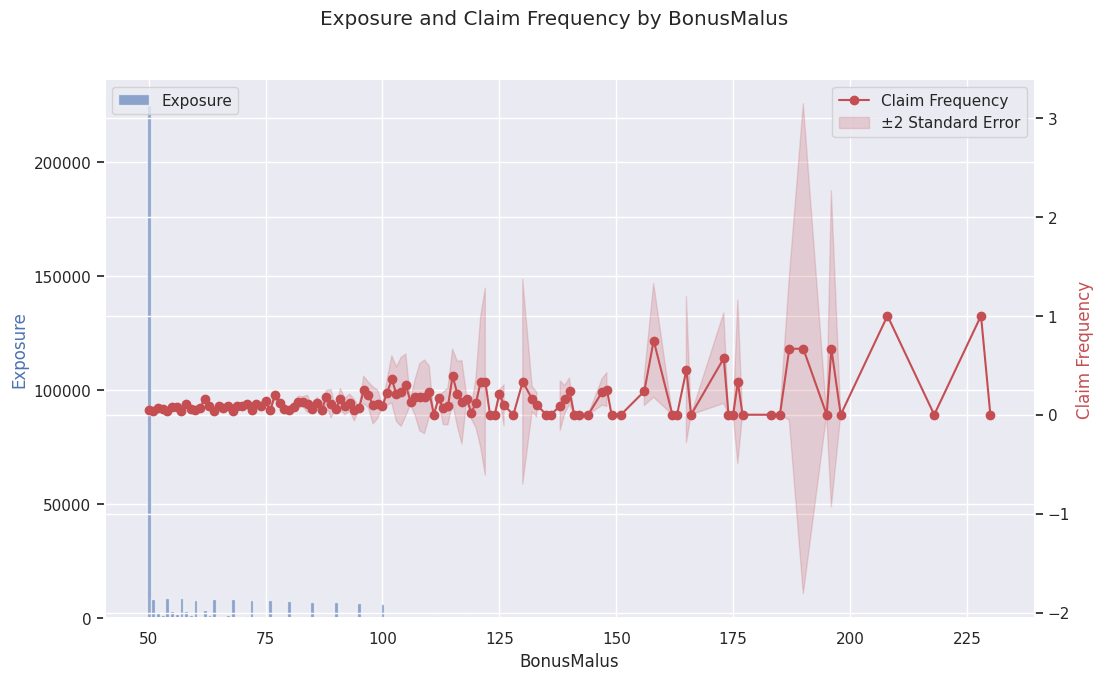

 BonusMalus             W        V      Std  SE_Lower  SE_Upper
         50 225233.130903 0.046882 0.222568  0.045944  0.047820
         51   8358.225595 0.034029 0.191123  0.029848  0.038210
         52   2725.955217 0.066038 0.263928  0.055928  0.076148
         53   1640.110809 0.059087 0.250552  0.046713  0.071460
         54   8701.567408 0.035138 0.192396  0.031013  0.039263
         55   3116.218284 0.074021 0.271881  0.064280  0.083762
         56   1783.430498 0.077034 0.281482  0.063704  0.090365
         57   8839.905709 0.037128 0.199692  0.032880  0.041376
         58   3218.448087 0.103518 0.322295  0.092155  0.114880
         59   1447.661380 0.061533 0.252046  0.048284  0.074782
         60   8153.974026 0.043483 0.213604  0.038752  0.048214
         61    758.543205 0.066125 0.264412  0.046924  0.085326
         62   3750.372052 0.160585 0.397416  0.147606  0.173564
         63   1601.566936 0.089934 0.298020  0.075040  0.104827
         64   8365.462549 0.037764 0.201

In [21]:
plot1way(df, 'BonusMalus', 'Exposure', 'ClaimNb', PrintTable=2, show2SE=True)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


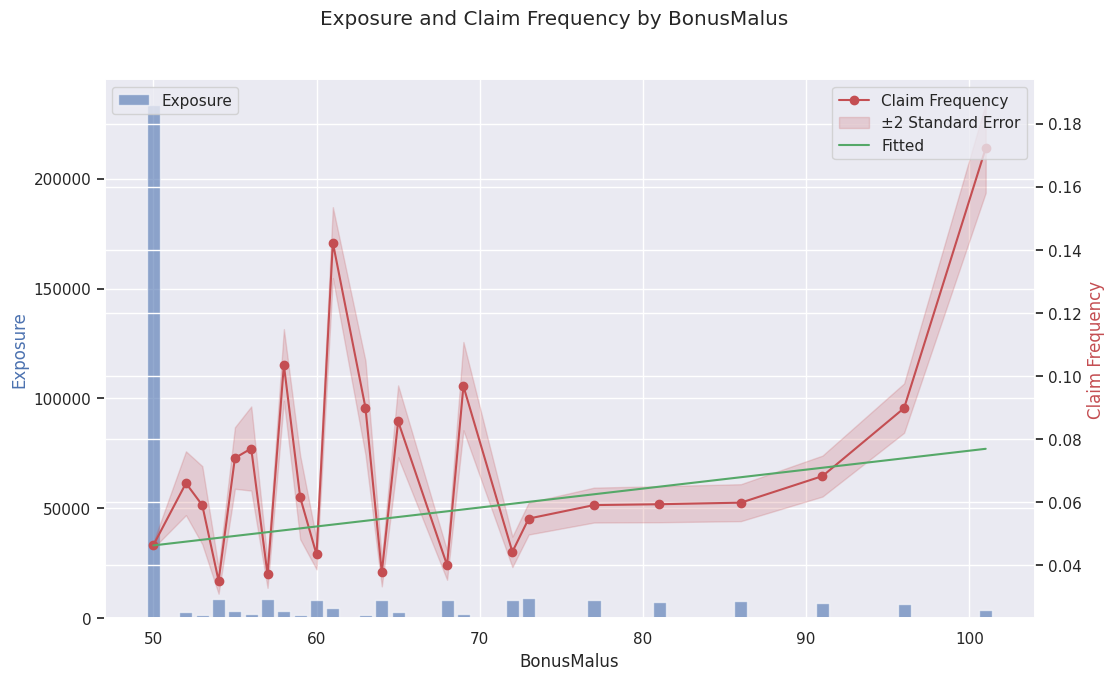

 BonusMalus             W        V      Std  SE_Lower  SE_Upper
         50 233591.356498 0.046372 0.221419  0.045456  0.047288
         52   2725.955217 0.066038 0.263928  0.055928  0.076148
         53   1640.110809 0.059087 0.250552  0.046713  0.071460
         54   8701.567408 0.035138 0.192396  0.031013  0.039263
         55   3116.218284 0.074021 0.271881  0.064280  0.083762
         56   1783.430498 0.077034 0.281482  0.063704  0.090365
         57   8839.905709 0.037128 0.199692  0.032880  0.041376
         58   3218.448087 0.103518 0.322295  0.092155  0.114880
         59   1447.661380 0.061533 0.252046  0.048284  0.074782
         60   8153.974026 0.043483 0.213604  0.038752  0.048214
         61   4508.915257 0.142296 0.377199  0.131061  0.153530
         63   1601.566936 0.089934 0.298020  0.075040  0.104827
         64   8365.462549 0.037764 0.201835  0.033350  0.042177
         65   2703.654792 0.085644 0.296412  0.074242  0.097045
         68   8253.954467 0.040072 0.210

In [22]:
plot1way(df, 'BonusMalus', 'Exposure', 'ClaimNb', PrintTable=2, show2SE=True, upper=101, polinomDegree=1, nbins=200)

Use the banding from upper=101 and nbins=200, and bin together 51&52, 54&55 and 80&85&90

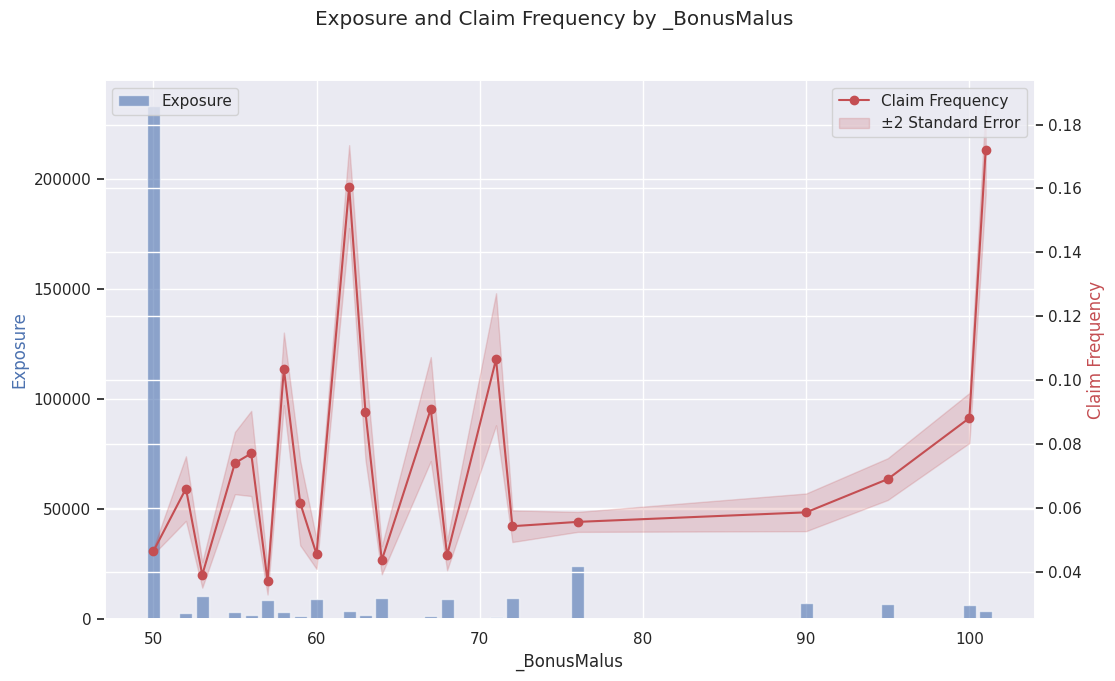

[50.0, 52.0, 53.0, 55.0, 57.0, 58.0, 59.0, 60.0, 62.0, 63.0, 64.0, 67.0, 68.0, 71.0, 72.0, 95.0, 100.0, 101.0]


In [23]:
banding={'BonusMalus':[50   ,52,53,   55,56,57,58,59,60,62,63,64,67,68,71,72,76,      90,95,100,101]}
df['_BonusMalus'] = df['BonusMalus'].apply(applyBanding, banding_values=banding['BonusMalus'])
plot1way(df, '_BonusMalus', 'Exposure', 'ClaimNb', recommendBanding=True)

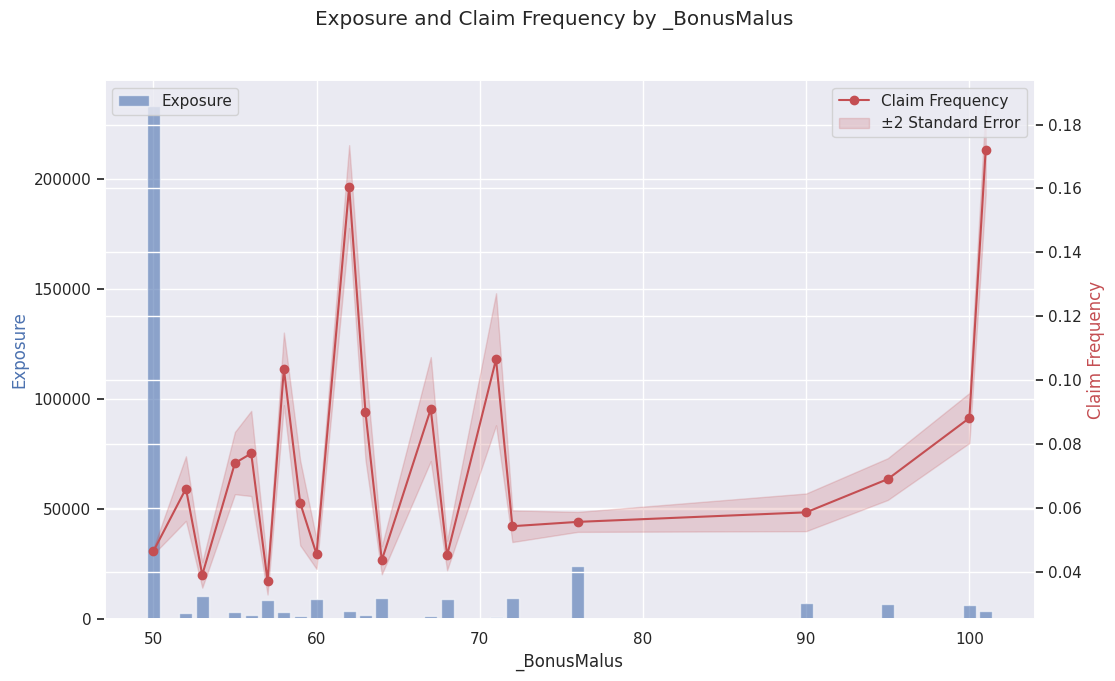

[50.0, 52.0, 53.0, 55.0, 57.0, 58.0, 59.0, 60.0, 62.0, 63.0, 64.0, 67.0, 68.0, 71.0, 72.0, 95.0, 100.0, 101.0]


In [24]:
plot1way(df, '_BonusMalus', 'Exposure', 'ClaimNb', recommendBanding=True)

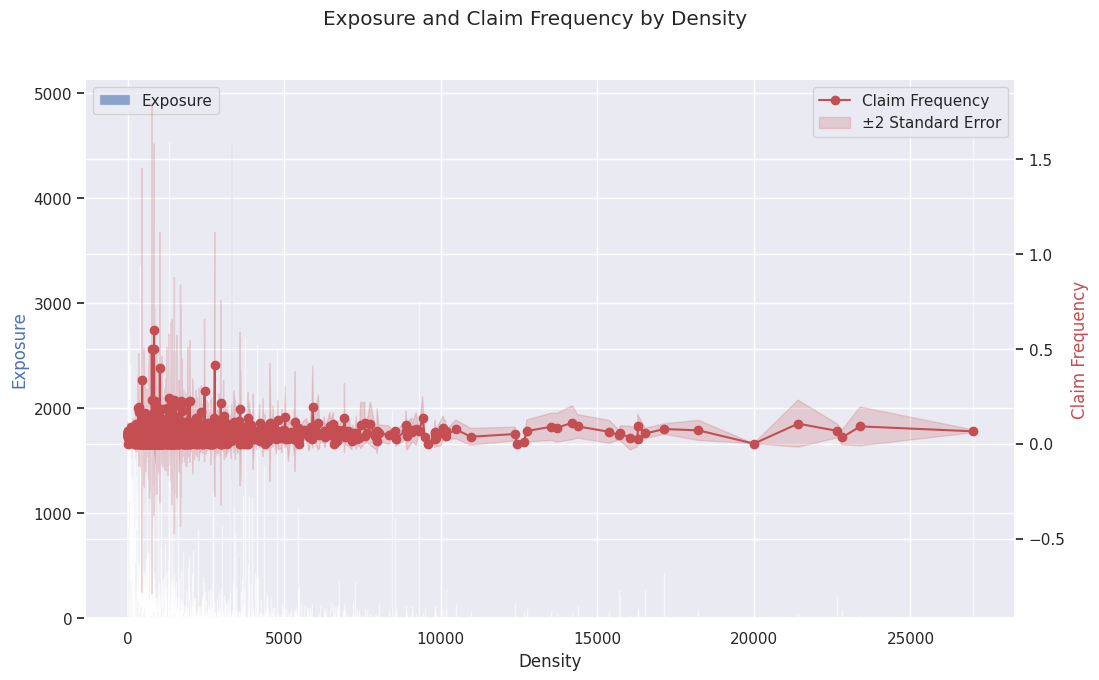

      Density            W         V       Std  SE_Lower  SE_Upper
0           1     2.070000  0.000000  0.000000  0.000000  0.000000
1           2    49.750000  0.043478  0.205049 -0.014664  0.101620
2           3   179.149156  0.049342  0.216938  0.016926  0.081758
3           4   138.725534  0.065693  0.276142  0.018803  0.112584
4           5   214.354658  0.066210  0.248933  0.032205  0.100215
...       ...          ...       ...       ...       ...       ...
1602    21410    38.700000  0.105263  0.385710 -0.018741  0.229267
1603    22669   202.650959  0.066955  0.258720  0.030606  0.103303
1604    22821    82.292847  0.032967  0.179043 -0.006506  0.072441
1605    23396    32.190000  0.090909  0.289683 -0.011207  0.193025
1606    27000  4886.307382  0.064955  0.265411  0.057361  0.072549

[1607 rows x 6 columns]


In [25]:
plot1way(df, 'Density', 'Exposure', 'ClaimNb', PrintTable=1)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


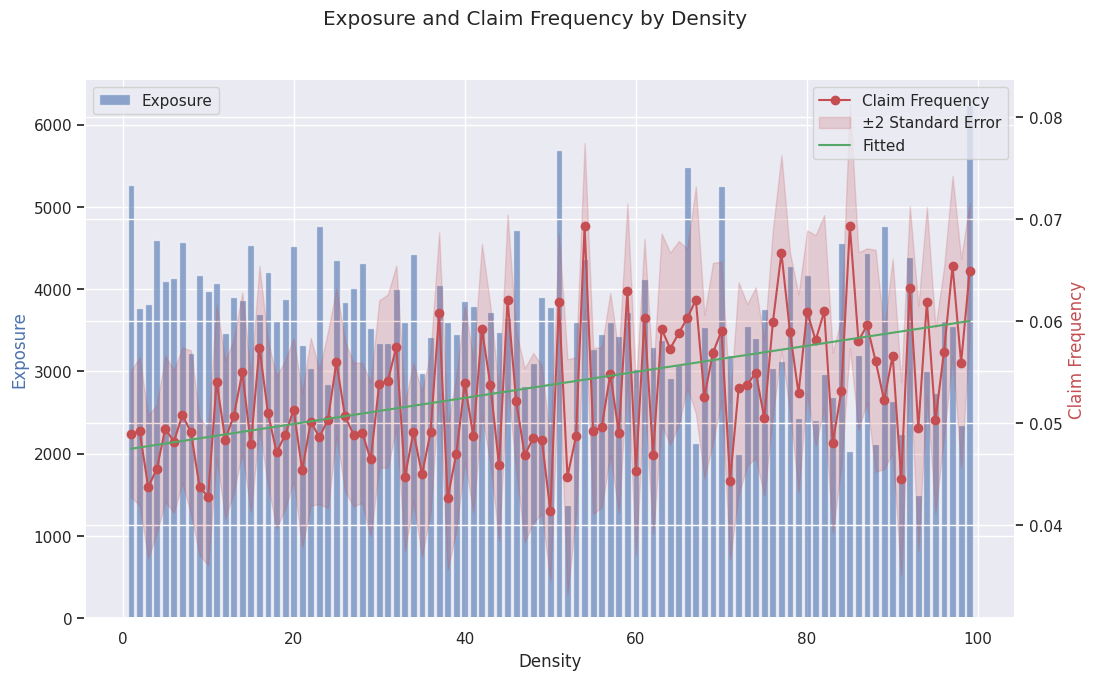

    Density            W         V       Std  SE_Lower  SE_Upper  value
0       1.0  5268.808029  0.048922  0.225494  0.042709  0.055135      1
1       2.0  3766.080963  0.049167  0.222377  0.041919  0.056414     11
2       3.0  3816.138976  0.043722  0.216259  0.036721  0.050724     13
3       4.0  4596.824901  0.045460  0.213284  0.039169  0.051752     15
4       5.0  4096.654540  0.049436  0.228139  0.042307  0.056565     18
..      ...          ...       ...       ...       ...       ...    ...
94     95.0  2740.772104  0.050266  0.238016  0.041173  0.059359   6308
95     96.0  3626.126355  0.056970  0.248623  0.048712  0.065227   7403
96     97.0  3554.992771  0.065388  0.262913  0.056569  0.074207   8561
97     98.0  2354.116122  0.055885  0.247787  0.045671  0.066099   9422
98     99.0  6238.002649  0.064895  0.263815  0.058214  0.071575  16052

[99 rows x 7 columns]


In [26]:
plot1way(df, 'Density', 'Exposure', 'ClaimNb', PrintTable=1, nbins=100, resetXaxis=True, polinomDegree=1)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


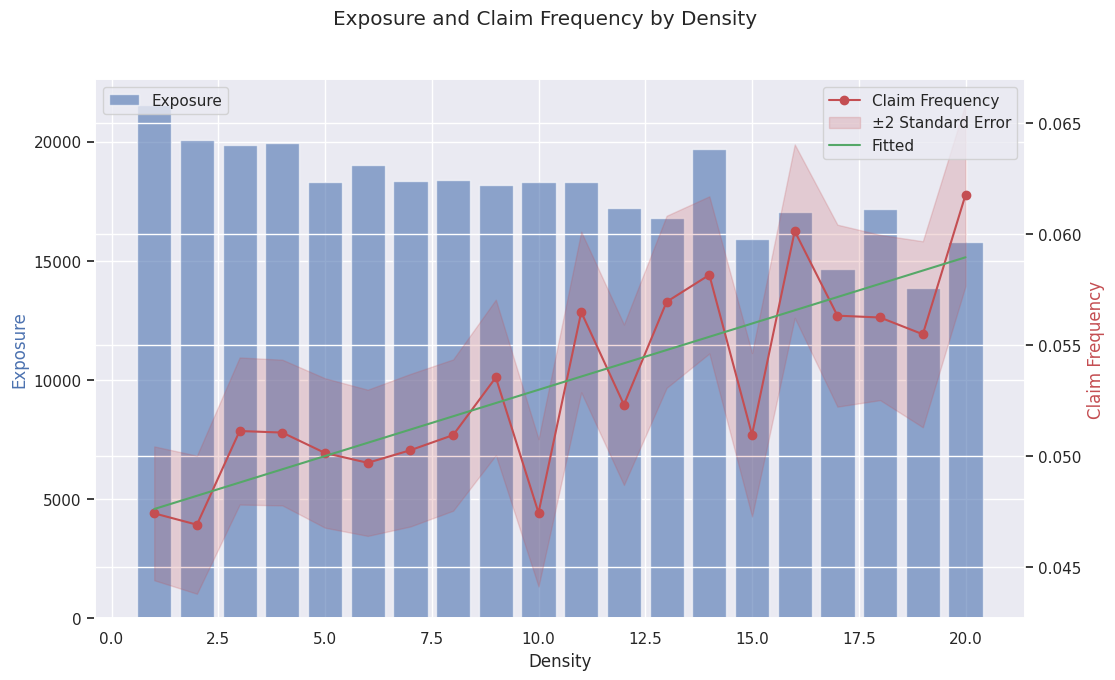

    Density             W         V       Std  SE_Lower  SE_Upper  value
0       1.0  21544.507409  0.047413  0.221300  0.044398  0.050429      1
1       2.0  20085.664941  0.046901  0.220497  0.043790  0.050013     21
2       3.0  19842.707028  0.051124  0.233427  0.047809  0.054438     34
3       4.0  19936.130186  0.051054  0.231727  0.047772  0.054336     50
4       5.0  18324.980335  0.050133  0.227841  0.046767  0.053500     68
5       6.0  19039.012525  0.049691  0.227279  0.046397  0.052985     93
6       7.0  18358.363230  0.050259  0.232855  0.046822  0.053696    123
7       8.0  18382.023479  0.050941  0.231084  0.047532  0.054349    165
8       9.0  18173.454202  0.053537  0.236273  0.050032  0.057042    215
9      10.0  18329.085426  0.047440  0.224759  0.044120  0.050761    287
10     11.0  18302.108120  0.056485  0.244830  0.052866  0.060105    394
11     12.0  17236.483838  0.052310  0.237405  0.048694  0.055927    512
12     13.0  16805.834692  0.056946  0.251339  0.05

In [27]:
plot1way(df, 'Density', 'Exposure', 'ClaimNb', PrintTable=1, nbins=20, resetXaxis=True, polinomDegree=1)

Density has some explanation power, but not enough to use as a banded one-hot-encoded variable, even constraining monotonity. The population/area is far from linearity, but there is a reasonable linear connection with the ventiles (aka vigintiles) and the claim frequency, for a price of only degree of freedom at the lienar coefficient. Therefore we band the density first and then reset the values to 1,2,3,...,20 to feed into the linear polinom.

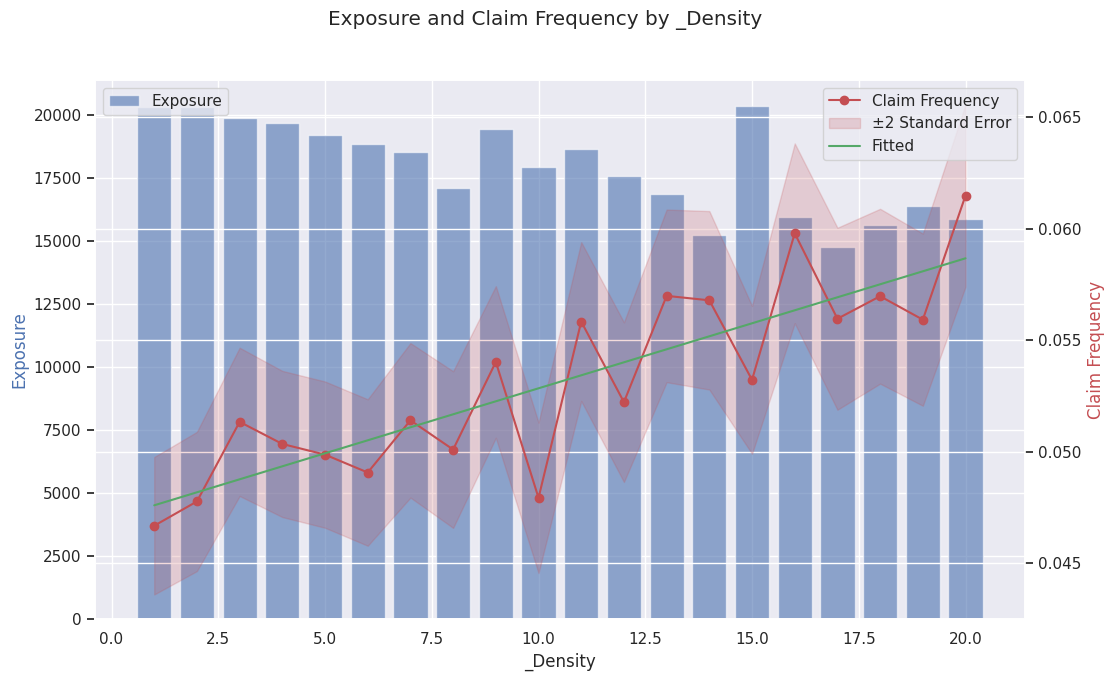

    _Density             W         V       Std  SE_Lower  SE_Upper
0          1  20308.905292  0.046686  0.219675  0.043603  0.049769
1          2  20309.259385  0.047776  0.222454  0.044654  0.050897
2          3  19857.998901  0.051345  0.234232  0.048021  0.054670
3          4  19692.789297  0.050354  0.229973  0.047076  0.053631
4          5  19208.255000  0.049876  0.227300  0.046595  0.053156
5          6  18855.608727  0.049074  0.225499  0.045789  0.052358
6          7  18508.683474  0.051414  0.235695  0.047949  0.054878
7          8  17117.295706  0.050103  0.229786  0.046591  0.053616
8          9  19421.129227  0.054031  0.236922  0.050631  0.057432
9         10  17947.850684  0.047939  0.225992  0.044565  0.051313
10        11  18658.351910  0.055843  0.243276  0.052281  0.059405
11        12  17559.489439  0.052230  0.237195  0.048650  0.055810
12        13  16865.360149  0.056996  0.251326  0.053125  0.060866
13        14  15222.494381  0.056797  0.246904  0.052794  0.06

In [28]:
#binning part
banding={'Density':[0,20,33,49,67,92,122,164,214,286,393,511,716,979,1313,1658,2715,3386,4128,7313]}
df['_Density'] = df['Density'].apply(applyBanding, banding_values=banding['Density'])
#resetting X axis
df['_Density'] = df['_Density'].rank(method='dense').astype(int)
plot1way(df, '_Density', 'Exposure', 'ClaimNb', PrintTable=1, polinomDegree=1)

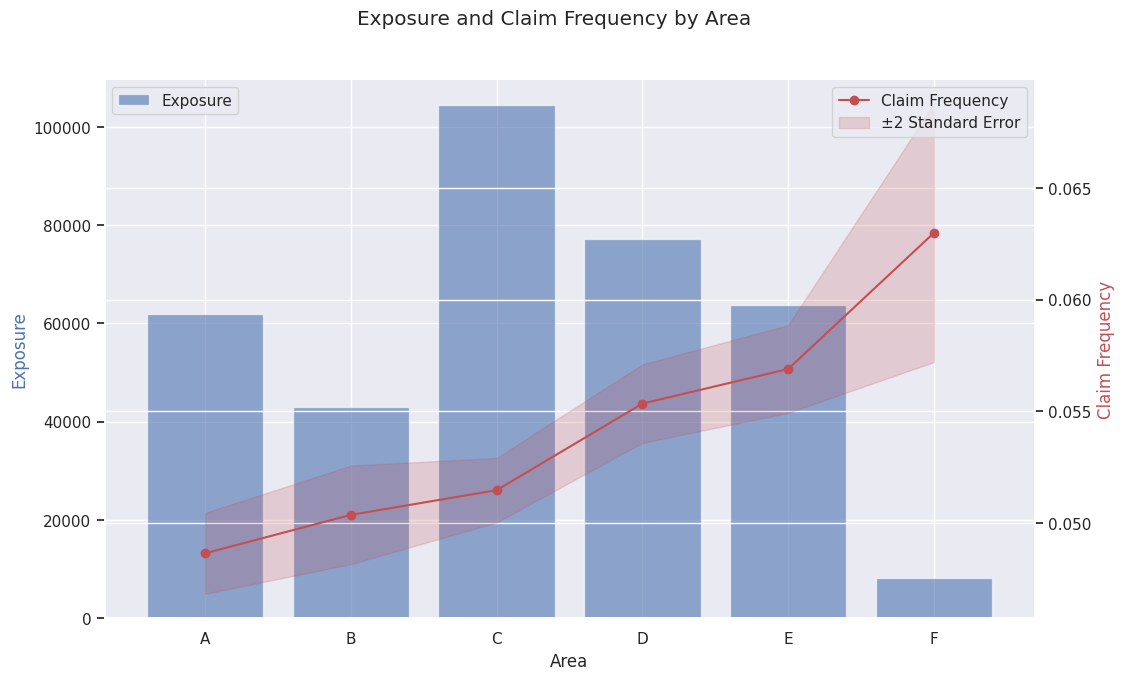

Area             W        V      Std  SE_Lower  SE_Upper
   A  61969.377712 0.048635 0.225541  0.046823  0.050448
   B  43012.323931 0.050358 0.228929  0.048151  0.052566
   C 104449.003785 0.051464 0.233267  0.050021  0.052908
   D  77120.191692 0.055344 0.244004  0.053587  0.057102
   E  63819.314270 0.056894 0.248231  0.054929  0.058859
   F   8129.234074 0.062994 0.260869  0.057208  0.068781
['A', 'C', 'D', 'F']


In [29]:
plot1way(df, 'Area', 'Exposure', 'ClaimNb', PrintTable=2, recommendBanding=True)

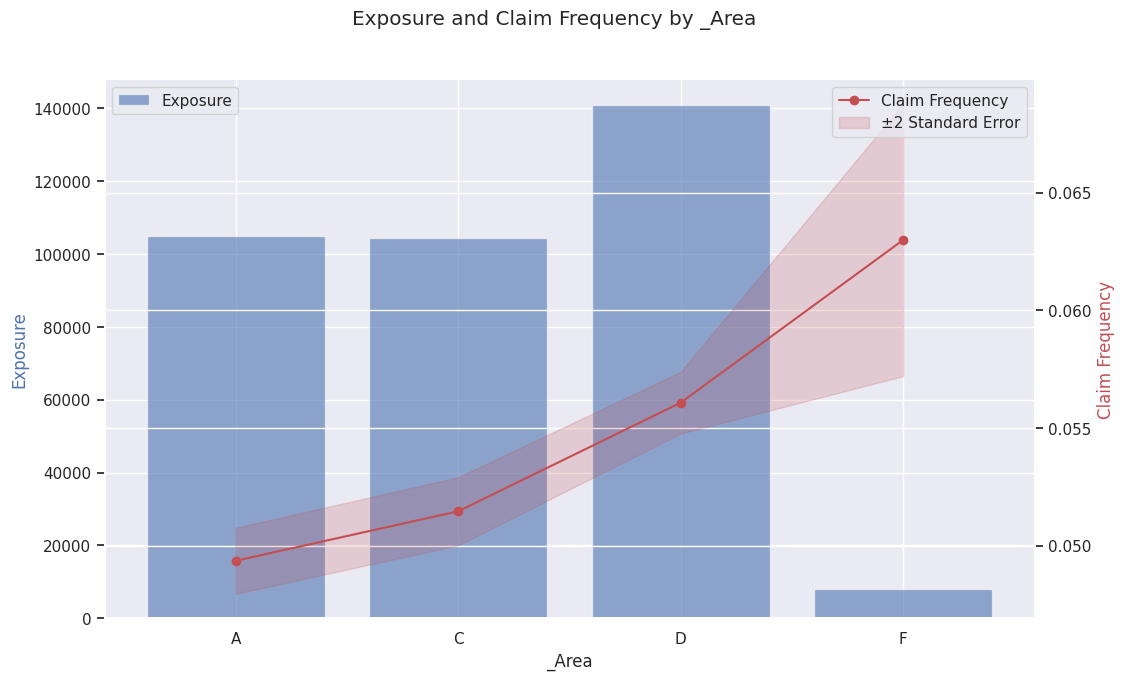

_Area             W        V      Std  SE_Lower  SE_Upper
    A 104981.701643 0.049360 0.226973  0.047959  0.050761
    C 104449.003785 0.051464 0.233267  0.050021  0.052908
    D 140939.505961 0.056081 0.246022  0.054770  0.057391
    F   8129.234074 0.062994 0.260869  0.057208  0.068781
['A', 'C', 'D', 'F']


In [30]:
mapping={'Area':{'B': 'A', 'E': 'D'}}
df['_Area'] = df['Area'].map(mapping['Area']).fillna(df['Area'])
plot1way(df, '_Area', 'Exposure', 'ClaimNb', PrintTable=2, recommendBanding=True)

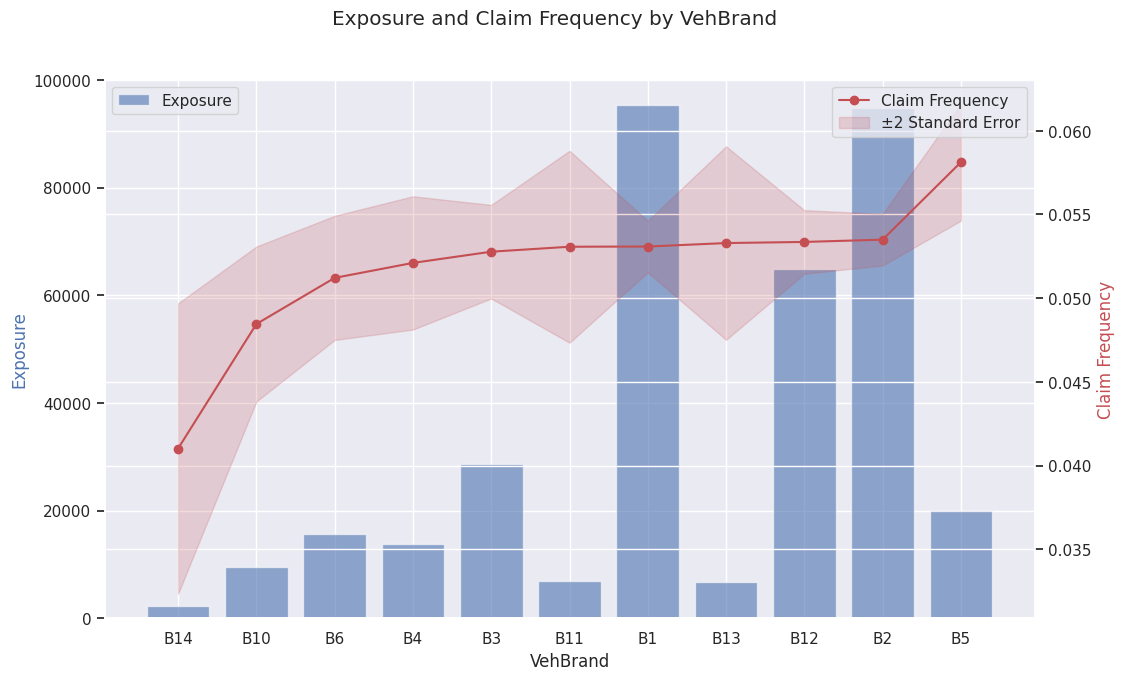

VehBrand            W        V      Std  SE_Lower  SE_Upper
     B14  2274.467743 0.041018 0.206895  0.032342  0.049694
     B10  9496.014123 0.048455 0.225509  0.043827  0.053084
      B6 15684.953599 0.051212 0.232197  0.047504  0.054920
      B4 13775.496080 0.052107 0.233574  0.048127  0.056087
      B3 28592.876331 0.052776 0.236216  0.049983  0.055570
     B11  6887.817279 0.053073 0.237889  0.047340  0.058806
      B1 95351.059578 0.053086 0.237540  0.051547  0.054625
     B13  6772.032216 0.053293 0.237769  0.047514  0.059071
     B12 64808.608718 0.053360 0.241219  0.051465  0.055255
      B2 94864.057101 0.053496 0.237360  0.051955  0.055038
      B5 19992.062695 0.058124 0.246790  0.054634  0.061615


In [31]:
plot1way(df, 'VehBrand', 'Exposure', 'ClaimNb', PrintTable=2, sortby='V')

B14 and B5 significantly different to any other brands. B10 looks also less claim frequent, when we'll group other brands together

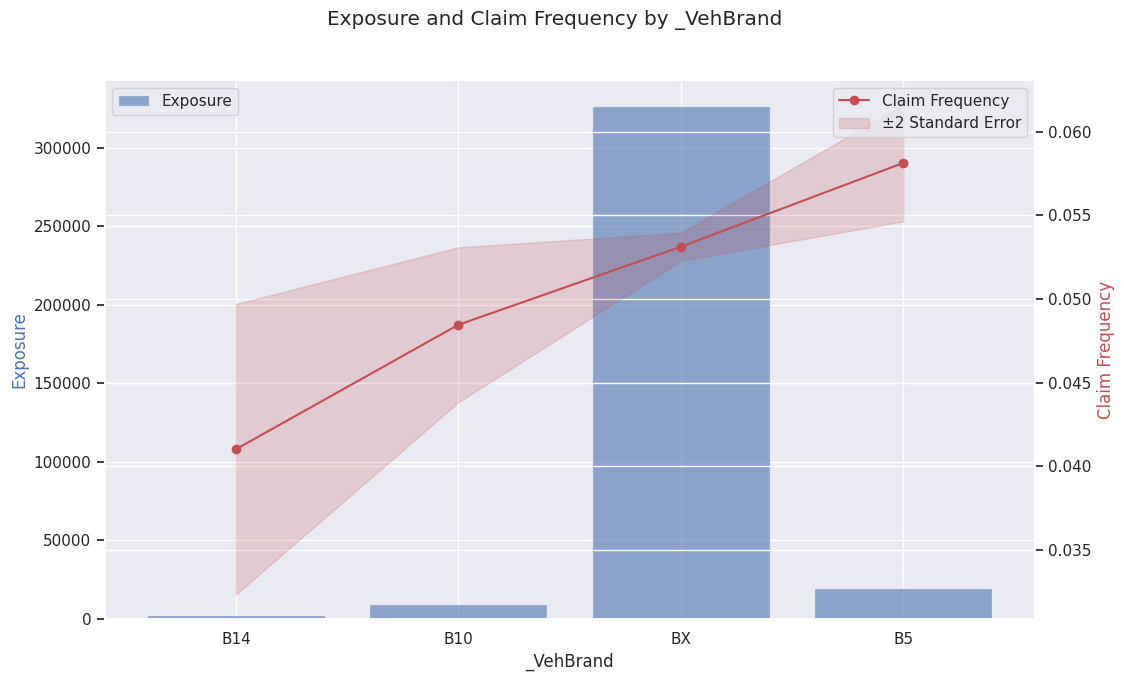

_VehBrand             W        V      Std  SE_Lower  SE_Upper
      B14   2274.467743 0.041018 0.206895  0.032342  0.049694
      B10   9496.014123 0.048455 0.225509  0.043827  0.053084
       BX 326736.900902 0.053116 0.237980  0.052283  0.053949
       B5  19992.062695 0.058124 0.246790  0.054634  0.061615


In [32]:
df['_VehBrand'] = df['VehBrand'].apply(lambda x: 'BX' if x not in ['B14', 'B10', 'B5'] else x)
plot1way(df, '_VehBrand', 'Exposure', 'ClaimNb', PrintTable=2, sortby='V')

Even the difference between the groups are significant, lacking reasonable exposure on the B5,B10,B14 VehBrand should be omitted from the model

In [33]:
df = df.drop('_VehBrand', axis=1)

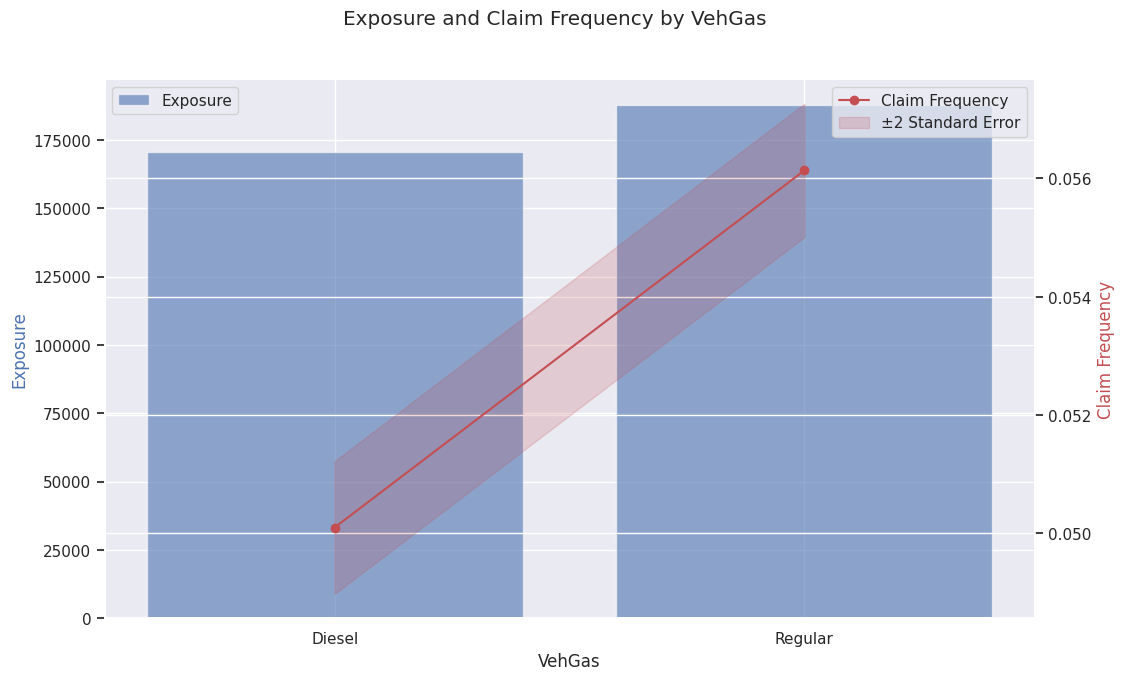

 VehGas             W        V      Std  SE_Lower  SE_Upper
 Diesel 170660.893127 0.050100 0.231282  0.048980  0.051220
Regular 187838.552336 0.056136 0.244154  0.055009  0.057262


In [34]:
plot1way(df, 'VehGas', 'Exposure', 'ClaimNb', PrintTable=2, sortby='V')

Diesel will get 1 and regular 0 to use in GLM.

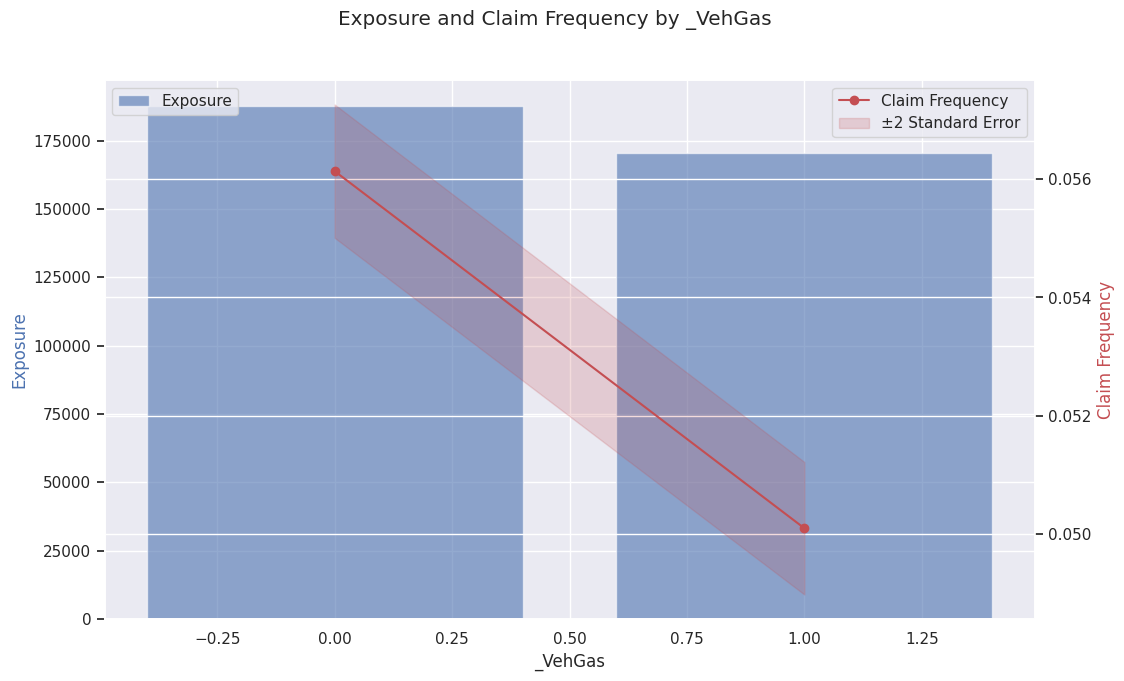

 _VehGas             W        V      Std  SE_Lower  SE_Upper
       0 187838.552336 0.056136 0.244154  0.055009  0.057262
       1 170660.893127 0.050100 0.231282  0.048980  0.051220


In [35]:
df['_VehGas'] = df['VehGas'].apply(lambda x: 1 if x == 'Diesel' else 0)
plot1way(df, '_VehGas', 'Exposure', 'ClaimNb', PrintTable=2)

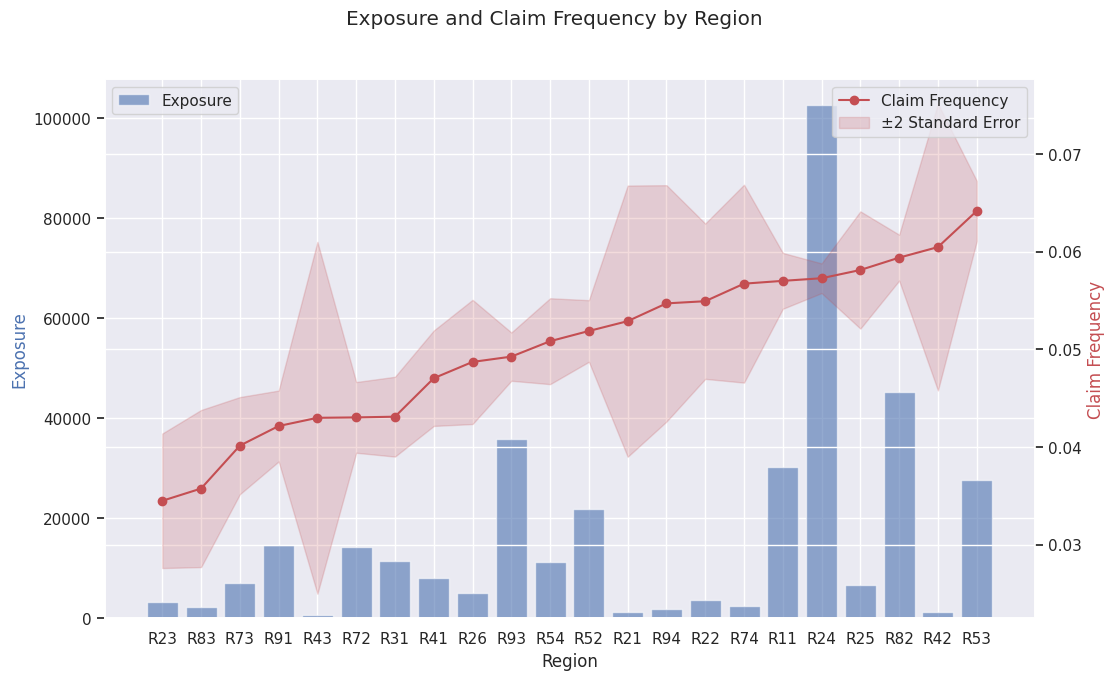

Region             W        V      Std  SE_Lower  SE_Upper
   R23   3177.682181 0.034495 0.193997  0.027612  0.041377
   R83   2322.884229 0.035748 0.193658  0.027712  0.043784
   R73   7020.108555 0.040138 0.208118  0.035170  0.045106
   R91  14736.104177 0.042145 0.220158  0.038518  0.045772
   R43    564.012946 0.042986 0.213771  0.024984  0.060989
   R72  14322.166692 0.043027 0.216469  0.039410  0.046645
   R31  11497.974269 0.043101 0.218895  0.039018  0.047183
   R41   8113.777972 0.047036 0.219929  0.042153  0.051919
   R26   5025.358609 0.048704 0.225213  0.042350  0.055058
   R93  35790.321015 0.049247 0.233642  0.046777  0.051717
   R54  11163.408715 0.050824 0.232195  0.046429  0.055220
   R52  21934.031165 0.051870 0.233445  0.048717  0.055022
   R21   1205.831509 0.052875 0.240894  0.039001  0.066749
   R94   1765.935399 0.054694 0.254088  0.042602  0.066787
   R22   3574.410221 0.054916 0.237510  0.046971  0.062861
   R74   2395.994542 0.056711 0.247772  0.046587  0.0668

In [36]:
plot1way(df, 'Region', 'Exposure', 'ClaimNb', PrintTable=2, sortby='V', recommendBanding=True)       

We'll use a dictionary to form significantly different groups of the regions
For default, R24 is obvious option, as it's the greatest by far. It happend to fall into a group called R11

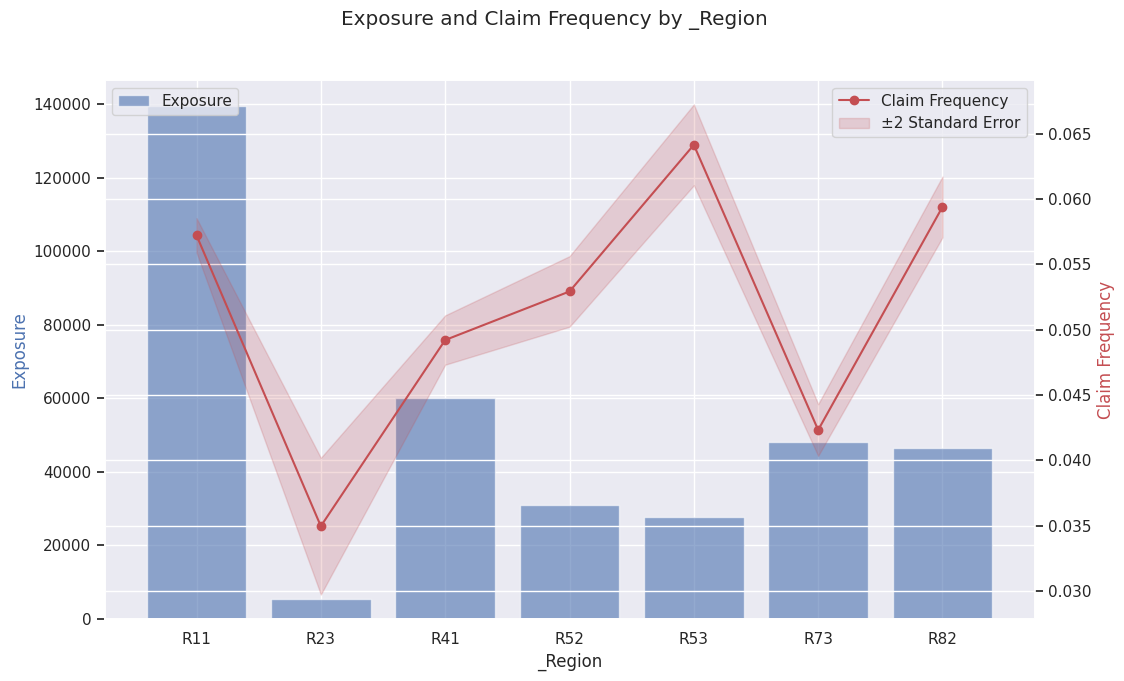

_Region             W        V      Std  SE_Lower  SE_Upper
    R11 139579.446482 0.057227 0.244702  0.055917  0.058537
    R23   5500.566410 0.034966 0.193864  0.029738  0.040193
    R41  60092.866312 0.049211 0.231272  0.047324  0.051098
    R52  30876.202836 0.052928 0.237158  0.050228  0.055627
    R53  27753.463675 0.064147 0.257398  0.061057  0.067237
    R73  48140.366639 0.042326 0.216962  0.040348  0.044304
    R82  46556.533109 0.059401 0.250362  0.057080  0.061721
['R11', 'R23', 'R41', 'R52', 'R53', 'R73', 'R82']


In [37]:
mapping={'Region':{
'R23':'R23',
'R83':'R23',
'R73':'R73',
'R91':'R73',
'R43':'R73',
'R72':'R73',
'R31':'R73',
'R41':'R41',
'R26':'R41',
'R93':'R41',
'R54':'R41',
'R52':'R52',
'R21':'R52',
'R94':'R52',
'R22':'R52',
'R74':'R52',
'R11':'R11',
'R24':'R11',
'R25':'R11',
'R82':'R82',
'R42':'R82',
'R53':'R53'
}}
df['_Region'] = df['Region'].map(mapping['Region']).fillna('R11')
plot1way(df, '_Region', 'Exposure', 'ClaimNb', PrintTable=2, recommendBanding=True)

In [38]:
df

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
0             1        1   0.10000    D         5       0       55   
1             3        1   0.77000    D         5       0       55   
2             5        1   0.75000    B         6       2       52   
3            10        1   0.09000    B         7       0       46   
4            11        1   0.84000    B         7       0       46   
...         ...      ...       ...  ...       ...     ...      ...   
678008  6114326        0   0.00274    E         4       0       54   
678009  6114327        0   0.00274    E         4       0       41   
678010  6114328        0   0.00274    D         6       2       45   
678011  6114329        0   0.00274    B         4       0       60   
678012  6114330        0   0.00274    B         7       6       29   

        BonusMalus VehBrand   VehGas  Density Region  ClaimFreq  fold  \
0               50      B12  Regular     1217    R82  10.000000     1   
1               50      B12  Regular     1217    R82   1.298701     5   
2               50      B12   Diesel       54    R22   1.333333     1   
3               50      B12   Diesel       76    R72  11.111111     1   
4               50      B12   Diesel       76    R72   1.190476     2   
...            ...      ...      ...      ...    ...        ...   ...   
678008          50      B12  Regular     3317    R93   0.000000     3   
678009          95      B12  Regular     9850    R11   0.000000     5   
678010          50      B12   Diesel     1323    R82   0.000000     5   
678011          50      B12  Regular       95    R26   0.000000     3   
678012          54      B12   Diesel       65    R72   0.000000     5   

        _VehPower  _VehAge  _DrivAge  _BonusMalus  _Density _Area  _VehGas  \
0               5        0        55           50        14     D        0   
1               5        0        55           50        14     D        0   
2               6        2        52           50         4     A        1   
3               7        0        46           50         5     A        1   
4               7        0        46           50         5     A        1   
...           ...      ...       ...          ...       ...   ...      ...   
678008          4        0        54           50        17     D        0   
678009          4        0        41           95        20     D        0   
678010          6        2        45           50        15     D        1   
678011          4        0        60           50         6     A        0   
678012          7        6        29           53         4     A        1   

       _Region  
0          R82  
1          R82  
2          R52  
3          R73  
4          R73  
...        ...  
678008     R41  
678009     R11  
678010     R82  
678011     R41  
678012     R73  

[678013 rows x 22 columns]

In [39]:
#Simply ask C() categorical
#df = pd.get_dummies(df, columns=['_VehPower','_VehAge','_BonusMalus','_Area','_Region'], drop_first=True)
#VehGas already 0=Regular 1=Diesel
#DrivAge:4
#Density:1

In [40]:
df_raw_ori = pd.read_csv("../input/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv")
df_raw_ori['Rounded_Exposure'] = df_raw_ori['Exposure'].round(1)
print(df_raw_ori.groupby('Rounded_Exposure').size().reset_index(name='count'))

    Rounded_Exposure   count
0                0.0   49342
1                0.1  102965
2                0.2   70505
3                0.3   44216
4                0.4   48552
5                0.5   56801
6                0.6   34198
7                0.7   33862
8                0.8   32394
9                0.9   22412
10               1.0  182195
11               1.1     257
12               1.2     155
13               1.3      58
14               1.4      38
15               1.5      29
16               1.6      14
17               1.7       5
18               1.8       5
19               1.9       5
20               2.0       5


ClaimNb >= 4 clearly must be grouped together

There are 3105 policies with only 1 day of exposure. 3 of them have 1 claim. This is OK
Policies with 1day < exposure < 1month looks like to have similar claim count - not claim frequency.
This means that the 2005 policy which has 2 days of exposure has 20 claims. This is not OK
We assume that the claim occurance follows Poission distribution
To get in line with our assumption with the data we moderatly trust,
beside of the obviously erroneus >1 exposures capping,
we also floor exposure to 1/12. This is absolutely in line with observation for 2~29 days, and significantly differs for 1 day exposure claim. We get over that problem statement that 3 claims' exposure should be 1/12 or 1/36, because of 1/12 still fits better than 1/365.

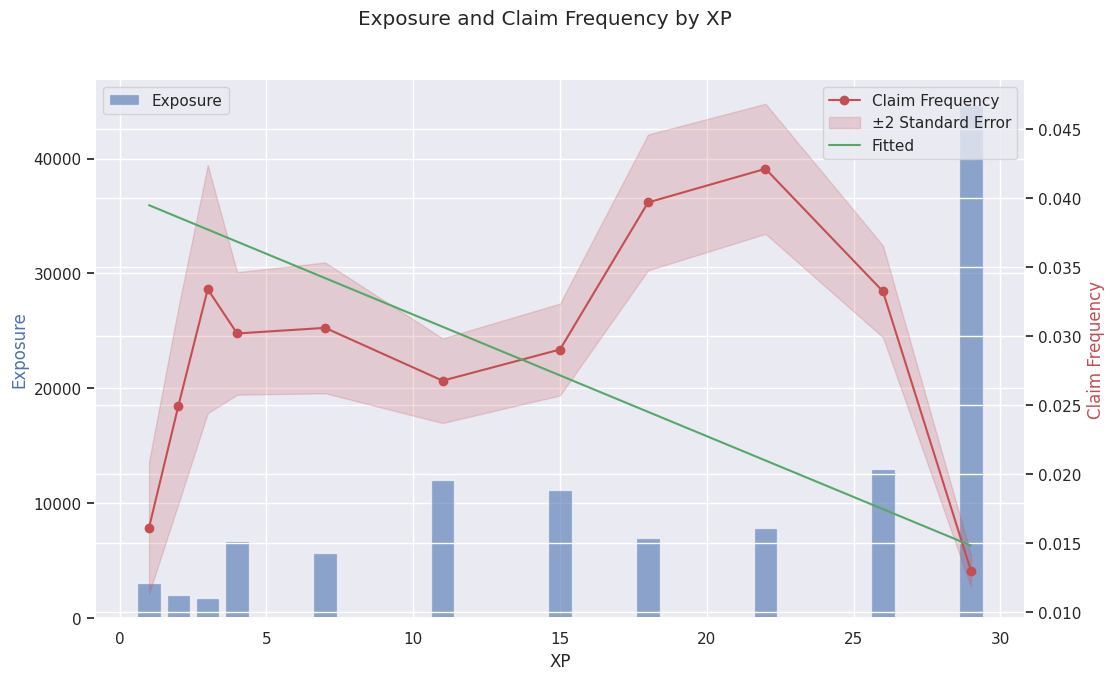

  XP     W        V      Std  SE_Lower  SE_Upper
 1.0  3105 0.016103 0.133349  0.011317  0.020889
 2.0  2005 0.024938 0.159141  0.017830  0.032046
 3.0  1767 0.033390 0.188920  0.024401  0.042378
 4.0  6726 0.030181 0.182047  0.025742  0.034621
 7.0  5656 0.030587 0.178266  0.025846  0.035328
11.0 11996 0.026759 0.167966  0.023692  0.029826
15.0 11131 0.029018 0.175710  0.025687  0.032349
18.0  6956 0.039678 0.205268  0.034756  0.044600
22.0  7812 0.042115 0.208372  0.037400  0.046830
26.0 12969 0.033233 0.189295  0.029909  0.036558
29.0 44670 0.012984 0.122331  0.011827  0.014142
[1.0, 2.0, 18.0, 26.0, 29.0]


In [41]:
#dfx=df[(31.5/365<df['Exposure'])&(df['Exposure']<1)].copy()
dfx=df[(df['Exposure']<=31.5/365)].copy()
dfx['XP']=round(dfx['Exposure']*365)
dfx['Exposure']=1
dfx['ClaimFreq']=dfx['ClaimNb']/dfx['XP']*365
plot1way(dfx, 'XP', 'Exposure', 'ClaimNb', PrintTable=2, recommendBanding=True, upper=365, polinomDegree=1)       

We can see here that exposures less than a full year but more than a month behaves tolerateably, still a bit deviates from the constant rate assumption.

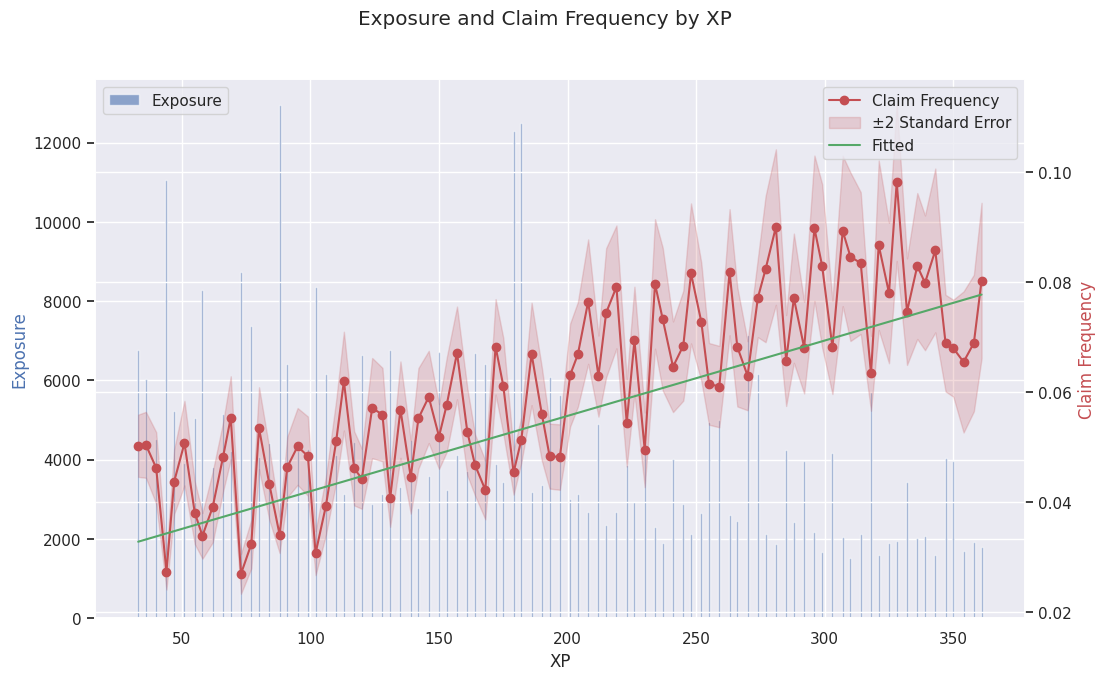

   XP     W        V      Std  SE_Lower  SE_Upper
 33.0  6760 0.050296 0.232351  0.044644  0.055948
 36.0  6043 0.050472 0.232855  0.044481  0.056462
 40.0  4516 0.046280 0.218384  0.039780  0.052779
 44.0 11047 0.027428 0.171448  0.024166  0.030691
 47.0  5229 0.043794 0.212902  0.037906  0.049683
 51.0  3919 0.050778 0.240647  0.043090  0.058466
 55.0  5060 0.038142 0.202592  0.032446  0.043838
 58.0  8281 0.033933 0.188902  0.029781  0.038085
 62.0  3827 0.039195 0.199398  0.032749  0.045642
 66.0  5141 0.048240 0.224924  0.041966  0.054514
 69.0  4226 0.055372 0.245693  0.047813  0.062930
 73.0  8727 0.027043 0.169810  0.023407  0.030678
 77.0  7371 0.032424 0.188995  0.028022  0.036827
 80.0  4076 0.053484 0.237750  0.046036  0.060932
 84.0  4430 0.043341 0.216542  0.036834  0.049848
 88.0 12950 0.034131 0.189074  0.030808  0.037454
 91.0  6416 0.046446 0.221297  0.040921  0.051972
 95.0  4225 0.050178 0.226846  0.043198  0.057157
 99.0  4276 0.048410 0.235444  0.041209  0.055611


In [42]:
dfx=df[(31.5/365<df['Exposure'])&(df['Exposure']<1)].copy()
dfx['XP']=round(dfx['Exposure']*365)
dfx['Exposure']=1
dfx['ClaimFreq']=dfx['ClaimNb']/dfx['XP']*365
plot1way(dfx, 'XP', 'Exposure', 'ClaimNb', PrintTable=2, recommendBanding=True, upper=365, polinomDegree=1)       

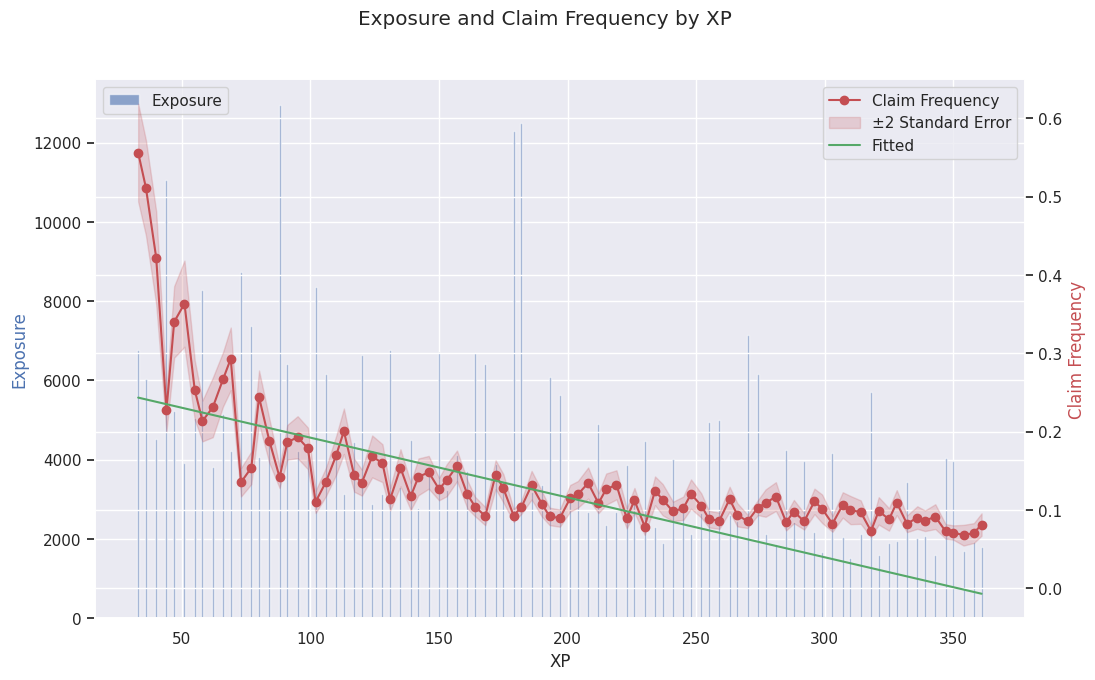

   XP     W        V      Std  SE_Lower  SE_Upper
 33.0  6760 0.556303 2.569948  0.493788  0.618817
 36.0  6043 0.511726 2.360892  0.450985  0.572467
 40.0  4516 0.422304 1.992754  0.362997  0.481611
 44.0 11047 0.227530 1.422236  0.200467  0.254593
 47.0  5229 0.340104 1.653389  0.294375  0.385833
 51.0  3919 0.363413 1.722277  0.308390  0.418436
 55.0  5060 0.253126 1.344472  0.215325  0.290927
 58.0  8281 0.213545 1.188783  0.187417  0.239672
 62.0  3827 0.230746 1.173878  0.192795  0.268697
 66.0  5141 0.266780 1.243897  0.232083  0.301477
 69.0  4226 0.292907 1.299682  0.252922  0.332893
 73.0  8727 0.135213 0.849050  0.117035  0.153390
 77.0  7371 0.153700 0.895887  0.132830  0.174570
 80.0  4076 0.244020 1.084736  0.210039  0.278001
 84.0  4430 0.188326 0.940928  0.160053  0.216600
 88.0 12950 0.141567 0.784228  0.127784  0.155350
 91.0  6416 0.186296 0.887622  0.164133  0.208459
 95.0  4225 0.192787 0.871564  0.165970  0.219605
 99.0  4276 0.178480 0.868050  0.151931  0.205030


In [43]:
plot1way(dfx, 'XP', 'Exposure', 'ClaimFreq', PrintTable=2, recommendBanding=True, upper=365, polinomDegree=1)       

In [44]:
df[(df['Exposure'] < 2/360) & (df['ClaimNb'] > 0)]

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  \
308         646        1  0.005464    D         6       0       45   
445         931        1  0.005464    C         6       0       75   
716        1489        1  0.002732    D         8       0       49   
914        1908        1  0.002732    C         5       0       33   
920        1921        1  0.002732    A         4       0       63   
...         ...      ...       ...  ...       ...     ...      ...   
401872  3088885        1  0.002740    A         4       8       28   
434961  3155836        1  0.005479    C         4      15       36   
578301  4169479        1  0.005464    C         4      20       19   
578774  4169952        1  0.005464    C         7       6       41   
604298  5018634        2  0.005479    E         6       4       44   

        BonusMalus VehBrand   VehGas  Density Region   ClaimFreq  fold  \
308             50      B12   Diesel     1472    R31  183.000000     3   
445             50      B12   Diesel      137    R52  183.000000     4   
716             50      B12  Regular      645    R11  366.000000     2   
914             67      B12  Regular      185    R93  366.000000     3   
920             50      B12  Regular       41    R91  366.000000     1   
...            ...      ...      ...      ...    ...         ...   ...   
401872          90       B2  Regular       19    R24  365.000000     4   
434961          64       B2  Regular      295    R24  182.500000     1   
578301         100       B1  Regular      405    R24  182.999996     5   
578774          90       B1  Regular      393    R91  182.999996     5   
604298          51      B12  Regular     7966    R31  365.000004     3   

        _VehPower  _VehAge  _DrivAge  _BonusMalus  _Density _Area  _VehGas  \
308             6        0        45           50        15     D        1   
445             6        0        73           50         7     C        1   
716             8        0        49           50        12     D        0   
914             5        0        33           67         8     C        0   
920             4        0        63           50         3     A        0   
...           ...      ...       ...          ...       ...   ...      ...   
401872          4        8        28           90         1     A        0   
434961          4       15        36           64        10     C        0   
578301          4       18        17          100        11     C        0   
578774          7        6        41           90        11     C        0   
604298          6        4        44           50        20     D        0   

       _Region  
308        R73  
445        R52  
716        R11  
914        R41  
920        R73  
...        ...  
401872     R11  
434961     R11  
578301     R11  
578774     R73  
604298     R73  

[96 rows x 22 columns]

### 1.5 Evaluation metrics and helper functions

Since the exposure is so different, we will exposure-weight the Poisson deviance and the corresponding functions.

In [45]:
# Modified function PDX: Weighted Poisson Deviance
def PDW(pred, obs, ex=None):
    if ex is None:
        ex = np.ones(len(obs))
    deviance = 200 * np.sum(ex * (pred - obs + np.log((obs / pred) ** obs))) / np.sum(ex)
    return deviance

In [46]:
# Function PDW2: Print Poisson Deviance learn/test
def PDW2(txt, l_c, l_x, l_e, t_c, t_x, t_e):
    print("%s, Learn/Test: %.2f %% / %.2f %%" % (txt, PDW(l_c, l_x, l_e), PDW(t_c, t_x, t_e)))

In [47]:
# Function CF2: Print claim frequency
def CF2(txt, l_c, l_x, t_c, t_x):
    print("%s: %.2f %% / %.2f %%" % (txt, sum(l_c)/sum(l_x)*100, sum(t_c)/sum(t_x)*100))

In [48]:
# Function Benchmark.GLM2: Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
def Benchmark_GLM2(txt, pred):
    index = ((PDW(pred, test2.ClaimNb, test2.Exposure) - PDW(test2.fit_cf, test2.ClaimNb, test2.Exposure)) 
             / (PDW(test2.fitGLM2, test2.ClaimNb, test2.Exposure) - PDW(test2.fit_cf, test2.ClaimNb, test2.Exposure))) * 100
    II.append(index)
    mname.append(txt)
    print("GLM2-Improvement-Index (PD test) of %s: %.1f %%" % (txt, index)) 

Helper functions

In [49]:
# model names list
mname = []

# GLM2-Improvment-Index
II = []

# Dictionary for PD and model names
dict = {'improvement': II, 'modelname': mname}

In [50]:
def plot_eval(d,x1,x2,t): 
    """
    This function graphically represents the forecast quality of the fitted models.
    Input parameter: Dictionary with model names, PD and Text
    """
    df_eval = pd.DataFrame(d)
    sns.set_style('darkgrid')
    plt.title("GLM2-Improvement-Index of the fitted models: " + t)
    sns.barplot(data = df_eval, x = "improvement", y = "modelname", color = 'magenta')
    plt.xlim(x1, x2)
    plt.show()

In [51]:
def plot_feature_importance(model, data, top_n=20, model_name=''): 
    """
    This function extracts and plots the most important features (if method feature_importance_ is available) 
    """
    # Extract the most important features and create a Series for plotting
    FI = pd.Series(model.feature_importances_, index=data.columns).nlargest(top_n)
    # Plot the feature importances
    FI.plot(kind='barh')
    plt.gca().invert_yaxis()
    text = 'Model {}: Top {} most important features'.format(model_name, top_n)
    plt.title(text)
    plt.xlabel('Importance')
    plt.show()

In [52]:
# generate sample with encoded data
learn = df.loc[df.fold != 5,].copy()    # 80%
test = df.loc[df.fold == 5,].copy()     # 20%
# Additionally, let's divide learn into train and validation (e.g. to use it for early stopping)
train = df.loc[df.fold < 4,].copy()    # 60%
val = df.loc[df.fold == 4,].copy()    # 20%
CF2("Claim Frequency (Actual) Train/Val", train.ClaimNb, train.Exposure, val.ClaimNb, val.Exposure)

Claim Frequency (Actual) Train/Val: 10.08 % / 10.00 %


In [53]:
#model = smf.glm("ClaimNb ~ C(_VehPower) + C(_VehAge) + C(_BonusMalus) + C(_Area) + C(_Region) + _VehGas + _Density + _DrivAge +  I(_DrivAge^2) + I(_DrivAge^3) + I(_DrivAge^4)"     ,  family=sm.families.Poisson(), offset = np.log(learn.Exposure), data=learn)
model = smf.glm("ClaimNb ~ C(_VehPower) + C(_VehAge) + C(_BonusMalus) + C(_Area) + C(_Region) + C(_VehGas)"     ,  family=sm.families.Poisson(), offset = np.log(learn.Exposure), data=learn)
# Optimizer: https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.fit.html
d_glm2 = model.fit(method='newton') # same results with 'nm', 'IRLS'
d_glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               542962
Model:                            GLM   Df Residuals:                   542917
Model Family:                 Poisson   Df Model:                           44
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:            -1.1257e+05
Date:                Sun, 08 Sep 2024   Deviance:                   1.6964e+05
Time:                        18:29:03   Pearson chi2:                 1.25e+06
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01828
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.5299      0.025    -60.321      0.000      -1.580      -1.480
C(_VehPower)[T.5]         0.1764      0.020      8.770      0.000       0.137       0.216
C(_VehPower)[T.6]         0.1900      0.020      9.404      0.000       0.150       0.230
C(_VehPower)[T.7]         0.1347      0.020      6.775      0.000       0.096       0.174
C(_VehPower)[T.8]        -0.0444      0.030     -1.475      0.140      -0.103       0.015
C(_VehPower)[T.9]         0.2934      0.024     12.197      0.000       0.246       0.341
C(_VehPower)[T.11]        0.1269      0.032      4.016      0.000       0.065       0.189
C(_VehAge)[T.1]          -1.2499      0.026    -48.224      0.000      -1.301      -1.199
C(_VehAge)[T.2]          -1.2099      0.022    -54.762      0.000      -1.253      -1.167
C(_VehAge)[T.4]          -1.1975      0.023    -51.722      0.000      -1.243      -1.152
C(_VehAge)[T.6]          -1.1422      0.024    -48.130      0.000      -1.189      -1.096
C(_VehAge)[T.8]          -1.2165      0.020    -61.282      0.000      -1.255      -1.178
C(_VehAge)[T.13]         -1.4071      0.028    -50.570      0.000      -1.462      -1.353
C(_VehAge)[T.15]         -1.5069      0.030    -51.027      0.000      -1.565      -1.449
C(_VehAge)[T.18]         -1.7100      0.042    -40.876      0.000      -1.792      -1.628
C(_BonusMalus)[T.52]      0.3978      0.063      6.321      0.000       0.274       0.521
C(_BonusMalus)[T.53]     -0.0037      0.040     -0.092      0.927      -0.082       0.075
C(_BonusMalus)[T.55]      0.4739      0.056      8.423      0.000       0.364       0.584
C(_BonusMalus)[T.56]      0.6087      0.069      8.818      0.000       0.473       0.744
C(_BonusMalus)[T.57]     -0.0755      0.045     -1.693      0.090      -0.163       0.012
C(_BonusMalus)[T.58]      0.8458      0.046     18.339      0.000       0.755       0.936
C(_BonusMalus)[T.59]      0.3546      0.086      4.146      0.000       0.187       0.522
C(_BonusMalus)[T.60]      0.1717      0.039      4.396      0.000       0.095       0.248
C(_BonusMalus)[T.62]      1.3253      0.034     38.975      0.000       1.259       1.392
C(_BonusMalus)[T.63]      0.8300      0.065     12.748      0.000       0.702       0.958
C(_BonusMalus)[T.64]      0.1431      0.038      3.751      0.000       0.068       0.218
C(_BonusMalus)[T.67]      0.7889      0.072     10.968      0.000       0.648       0.930
C(_BonusMalus)[T.68]      0.2208      0.038      5.881      0.000       0.147       0.294
C(_BonusMalus)[T.71]      1.0238      0.076     13.419      0.000       0.874       1.173
C(_BonusMalus)[T.72]      0.4460      0.034     13.299      0.000       0.380       0.512
C(_BonusMalus)[T.76]      0.4983      0.021     23.189      0.000       0.456       0.540
C(_BonusMalus)[T.90]   

In [54]:
betas=pd.DataFrame(data=d_glm2.params.reset_index())
betas.columns=['featurevalue','beta']
betas

featurevalue      beta
0               Intercept -1.529874
1       C(_VehPower)[T.5]  0.176393
2       C(_VehPower)[T.6]  0.189976
3       C(_VehPower)[T.7]  0.134708
4       C(_VehPower)[T.8] -0.044350
5       C(_VehPower)[T.9]  0.293407
6      C(_VehPower)[T.11]  0.126944
7         C(_VehAge)[T.1] -1.249877
8         C(_VehAge)[T.2] -1.209936
9         C(_VehAge)[T.4] -1.197489
10        C(_VehAge)[T.6] -1.142187
11        C(_VehAge)[T.8] -1.216467
12       C(_VehAge)[T.13] -1.407124
13       C(_VehAge)[T.15] -1.506904
14       C(_VehAge)[T.18] -1.709981
15   C(_BonusMalus)[T.52]  0.397799
16   C(_BonusMalus)[T.53] -0.003670
17   C(_BonusMalus)[T.55]  0.473881
18   C(_BonusMalus)[T.56]  0.608721
19   C(_BonusMalus)[T.57] -0.075500
20   C(_BonusMalus)[T.58]  0.845769
21   C(_BonusMalus)[T.59]  0.354645
22   C(_BonusMalus)[T.60]  0.171662
23   C(_BonusMalus)[T.62]  1.325309
24   C(_BonusMalus)[T.63]  0.829993
25   C(_BonusMalus)[T.64]  0.143105
26   C(_BonusMalus)[T.67]  0.788907
27   C(_BonusMalus)[T.68]  0.220768
28   C(_BonusMalus)[T.71]  1.023777
29   C(_BonusMalus)[T.72]  0.446028
30   C(_BonusMalus)[T.76]  0.498252
31   C(_BonusMalus)[T.90]  0.540574
32   C(_BonusMalus)[T.95]  0.791894
33  C(_BonusMalus)[T.100]  1.194619
34  C(_BonusMalus)[T.101]  1.546816
35          C(_Area)[T.C]  0.062323
36          C(_Area)[T.D]  0.158342
37          C(_Area)[T.F]  0.155797
38      C(_Region)[T.R23] -0.251084
39      C(_Region)[T.R41] -0.072296
40      C(_Region)[T.R52] -0.006235
41      C(_Region)[T.R53]  0.039348
42      C(_Region)[T.R73] -0.133237
43      C(_Region)[T.R82]  0.029235
44        C(_VehGas)[T.1] -0.097246

In [75]:
example=learn.loc[0:0,:].T.reset_index()
example.columns=['feature','value']
example['featurevalue']=example.apply(lambda row:f"C({row['feature']})[T.{row['value']}]",axis=1)
example=pd.concat([pd.DataFrame({'feature': ['_I'], 'value': [''],'featurevalue':['Intercept']}), example]).reset_index(drop=True)
#example=pd.concat([pd.DataFrame({'feature': [''], 'value': [''],'featurevalue':['Exposure'],'beta':example.loc[0:0,'Exposure']})
#                 , pd.merge(example, betas, on='featurevalue', how='inner')]).reset_index(drop=True)
example=pd.merge(example, betas, on='featurevalue', how='left')
example=pd.concat([pd.DataFrame({'feature': ['_E'], 'value': [''],'featurevalue':['Exposue'],'beta':learn.loc[0:0,'Exposure']}), example]).reset_index(drop=True)
example.fillna(0,inplace=True)
example.loc[example['feature'].str.startswith('_')]

feature value          featurevalue      beta
0            _E                     Exposue  0.100000
1            _I                   Intercept -1.529874
16    _VehPower     5     C(_VehPower)[T.5]  0.176393
17      _VehAge     0       C(_VehAge)[T.0]  0.000000
18     _DrivAge    55     C(_DrivAge)[T.55]  0.000000
19  _BonusMalus    50  C(_BonusMalus)[T.50]  0.000000
20     _Density    14     C(_Density)[T.14]  0.000000
21        _Area     D         C(_Area)[T.D]  0.158342
22      _VehGas     0       C(_VehGas)[T.0]  0.000000
23      _Region   R82     C(_Region)[T.R82]  0.029235

In [ ]:
np.exp(example.beta.sum())

In [ ]:
example['fitGLM2']

In [56]:
#df["fitGLM2"] = d_glm2.predict(df) * df.Exposure
#df["Err"]=df["fitGLM2"]-df["ClaimNb"]
learn["fitGLM2"] = d_glm2.predict(learn) * learn.Exposure
#learn["Err"]=learn["fitGLM2"]-learn["ClaimNb"]
test["fitGLM2"] = d_glm2.predict(test) * test.Exposure
#test["Err"]=test["fitGLM2"]-test["ClaimNb"]

In [57]:
def plotave(df, GroupByColList, WeightCol, ValueCol, PredictedCol=None, ChallengerCol=None, PrintTable=None, nbins=None, lower=None, upper=None
             ,show2SE=True, resetXaxis=False, polinomDegree=None, recommendBanding=False, silent=False
            ,sortby=None):
    if not isinstance(GroupByColList, list):
        GroupByColList=[GroupByColList]
    for GroupByCol in GroupByColList:
        # Group by GroupByCol and aggregate
        result=df.copy()
        if lower is not None:
            result[GroupByCol]=np.maximum(lower, result[GroupByCol])
        if upper is not None:
            result[GroupByCol]=np.minimum(upper, result[GroupByCol])
        if nbins is not None:
            #print(pd.Series(result['bins'].unique()).sort_values().reset_index(drop=True))
            result['bins']=pd.qcut(result[GroupByCol], q=nbins, duplicates='drop')
            result['ori']=result[GroupByCol]
            result[GroupByCol] = result.groupby('bins')[GroupByCol].transform('min')
            #print(result.drop_duplicates(subset=['ori',GroupByCol,'bins']).sort_values(by='ori').reset_index(drop=True))
            #print(result)
            #result[GroupByCol]=result[GroupByCol].groupby(bins).min()
        result = result.groupby(GroupByCol).agg(
            W=(WeightCol, 'sum'),
            V=(ValueCol, 'mean'),
            P=(PredictedCol if PredictedCol is not None else ValueCol, 'mean'),
            C=(ChallengerCol if ChallengerCol is not None else ValueCol, 'mean'),
            Std=(ValueCol, 'std')
        ).reset_index()
        
                


        # Calculate Standard Error
        result['SE_Lower']=result['V']-2*result["Std"]/np.sqrt(result['W'])
        result['SE_Upper']=result['V']+2*result["Std"]/np.sqrt(result['W'])

        # Sorting
        if sortby is None:
            sortby=GroupByCol
            result = result.sort_values(by=sortby).reset_index(drop=True)


        # Optinally recommend binning, using upper, lower and nbins, before of optional resetXaxis
        if recommendBanding:
            binning_df=RecommendBandingFunc(result, GroupByCol)

        if not silent:
            if resetXaxis:
                result['value']=result[GroupByCol]
                result[GroupByCol]=result[GroupByCol].rank(method='dense', ascending=True)

            # Plotting
            fig, ax1 = plt.subplots()

            # Bar chart for the sum of Exposure
            ax1.bar(result[GroupByCol], result['W'], color='b', alpha=0.6, label='Exposure')
            ax1.set_xlabel(GroupByCol)
            ax1.set_ylabel('Exposure', color='b')

            # Create a second y-axis for the line chart
            ax2 = ax1.twinx()
            ax2.plot(result[GroupByCol], result['V'], color='r', marker='o', label='Actual')
            ax2.set_ylabel('Claim Frequency', color='r')

            # Optionally Plot Predicted
            if PredictedCol is not None:
                ax2.plot(result[GroupByCol], result['P'], color='orange', marker='o', label='Predicted')
            if ChallengerCol is not None:
                ax2.plot(result[GroupByCol], result['C'], color='yellow', marker='o', label='Predicted')

            # Optionally plot +/- 2× Standard Error
            if show2SE:
                ax2.fill_between(result[GroupByCol], result['SE_Lower'], result['SE_Upper'], color='r', alpha=0.2, label='Actual ±2 Standard Error')

            # Optinally fit polinom (if ResetXaxis then on 1,2,3,... otherwise on actual numbers)
            if polinomDegree is not None:
                coefficients = np.polyfit(result[GroupByCol], result['V'], polinomDegree, w=result['W'])
                polynomial = np.poly1d(coefficients)
                y_fit = polynomial(result[GroupByCol])
                ax2.plot(result[GroupByCol], y_fit, color='g', label='Fitted')



            fig.suptitle('Exposure and Claim Frequency by ' + GroupByCol)

            # Add legends
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')

            plt.show()

            # Optionally Print Table in shortened or full view
            if PrintTable==1:
                print(result)
            if PrintTable==2:
                print(result.to_string(index=False))

            # Printing if banding recommendation requested
            if recommendBanding:
                print(binning_df)
        elif recommendBanding:
            #return(binning_df)
            pass

In [58]:
features=['_VehPower', '_VehAge', '_BonusMalus', '_Area', '_Region', '_VehGas', '_DrivAge', '_Density']

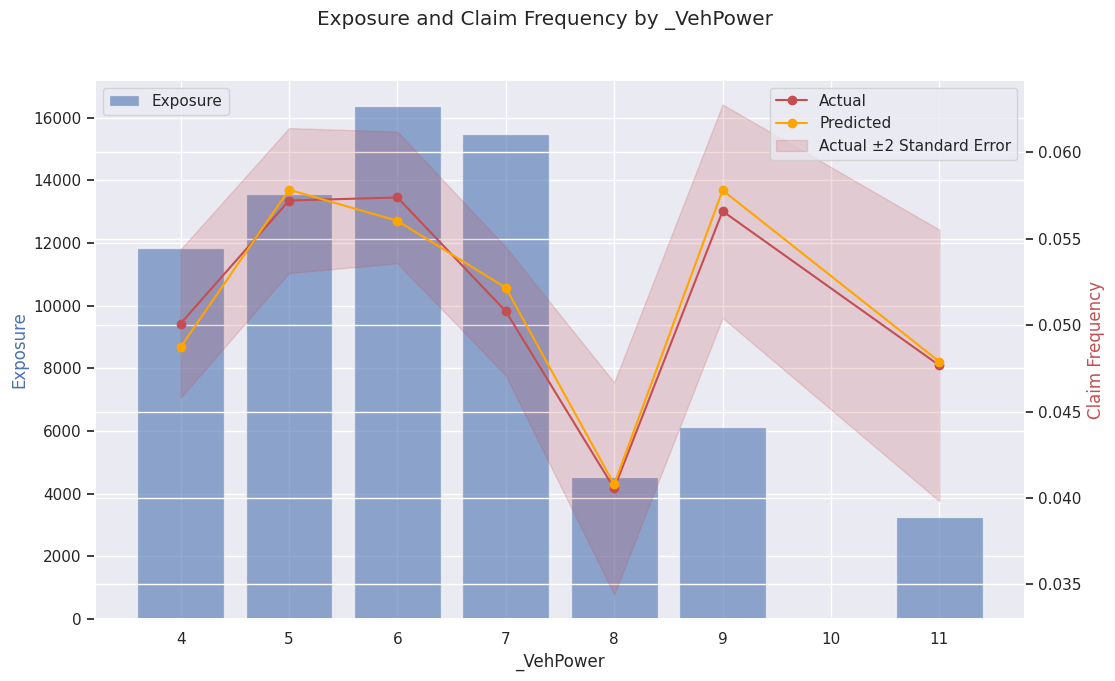

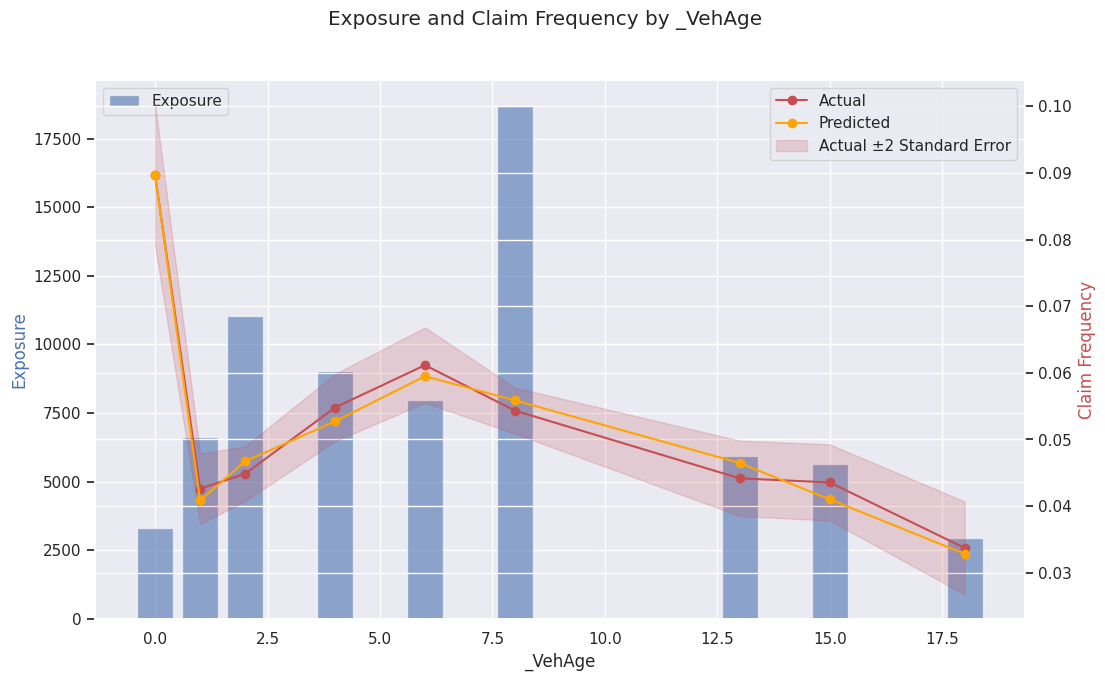

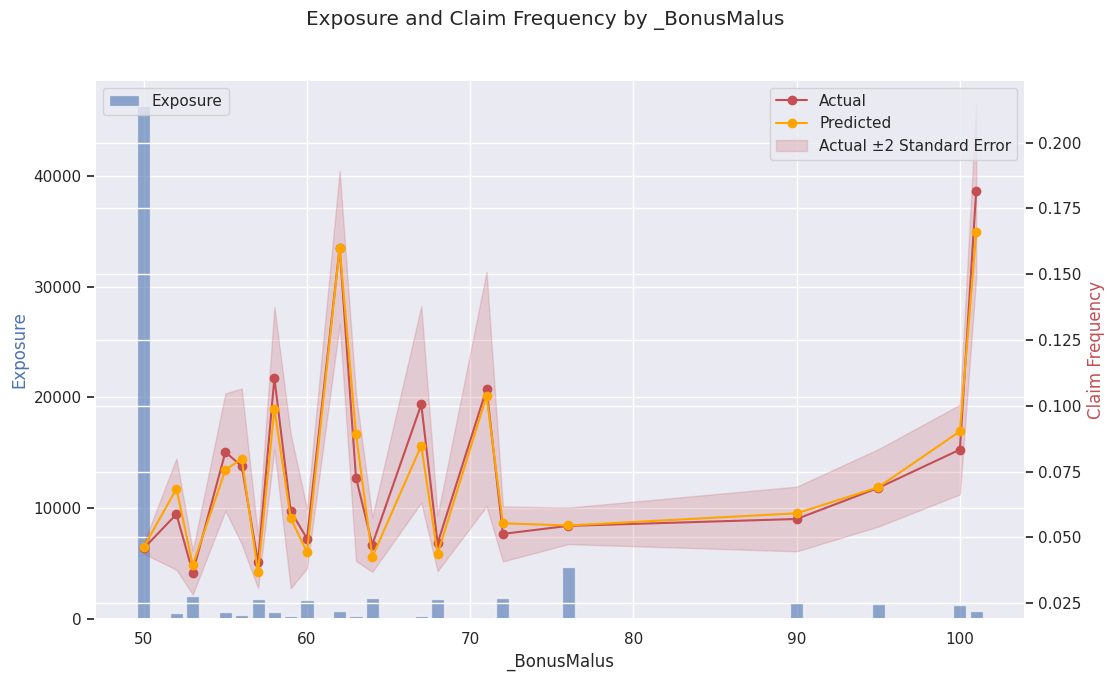

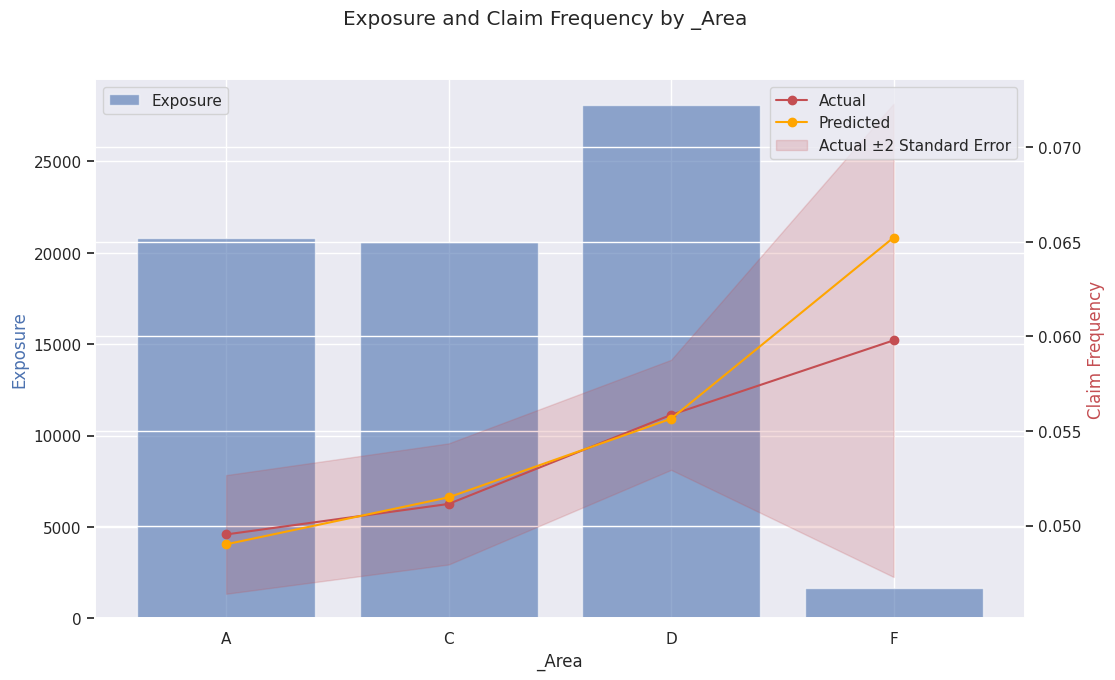

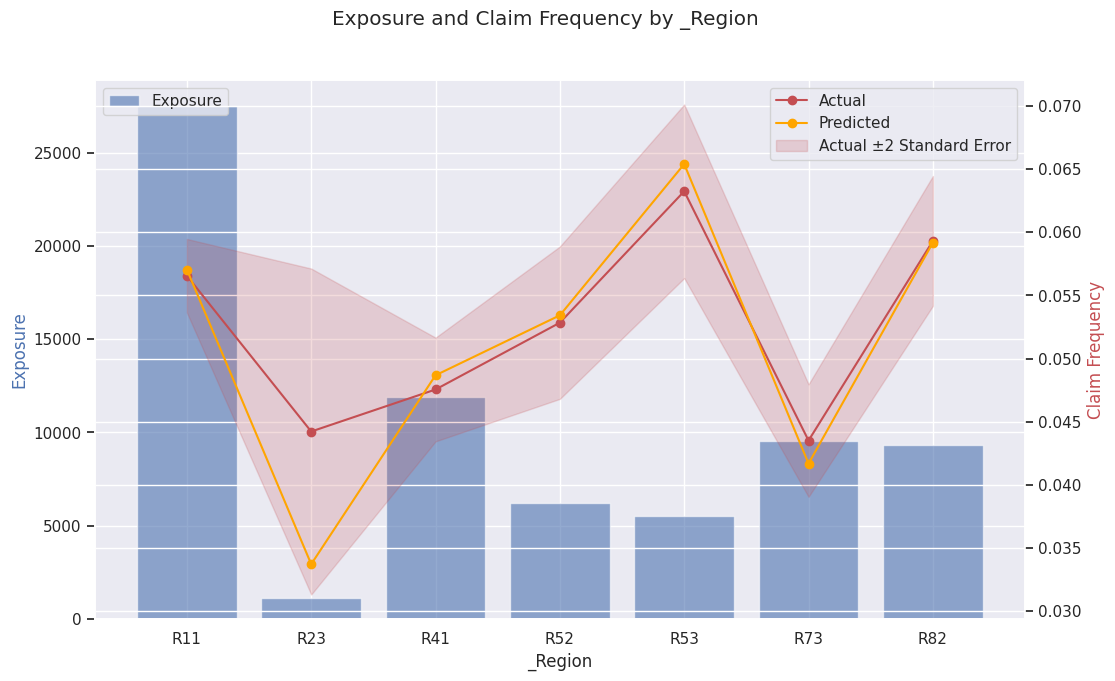

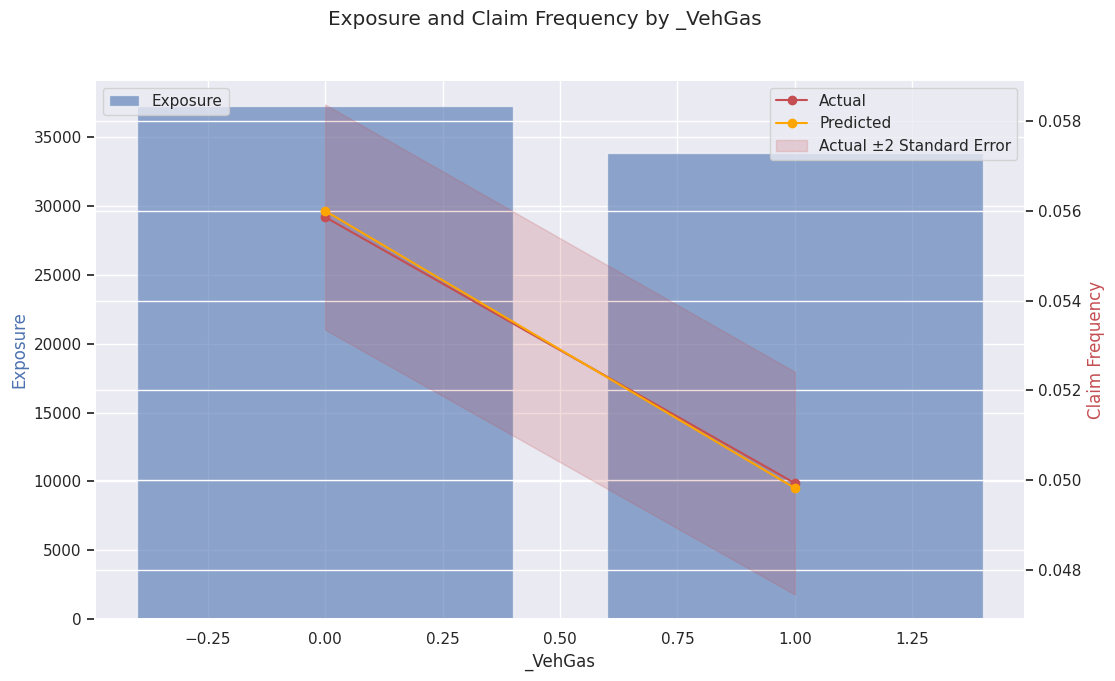

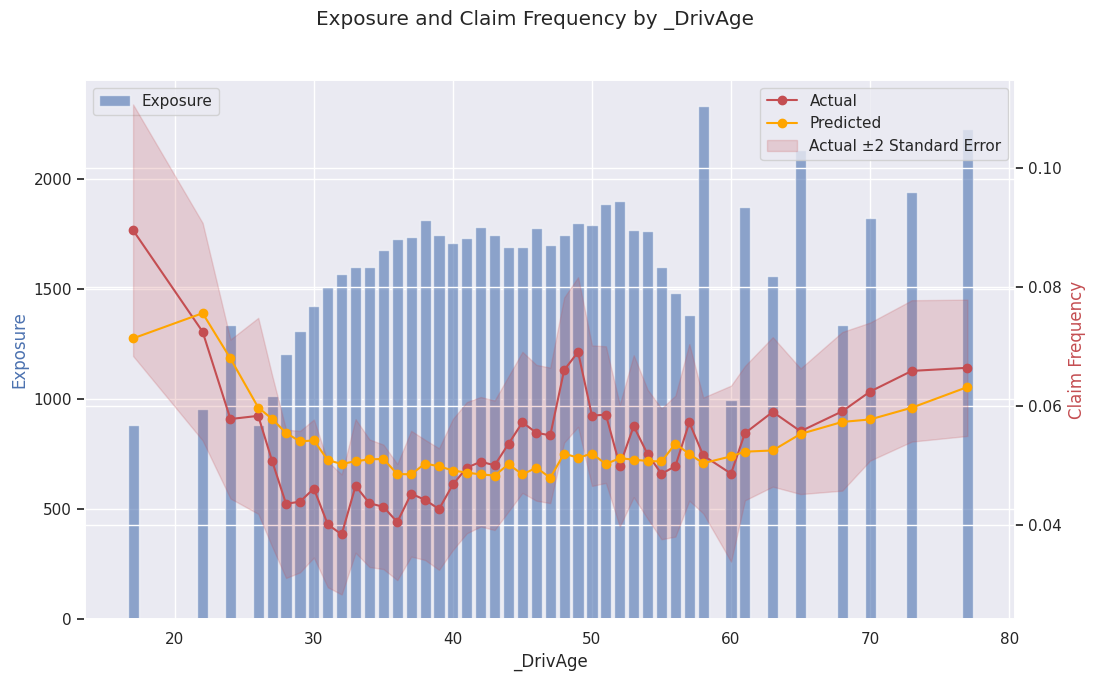

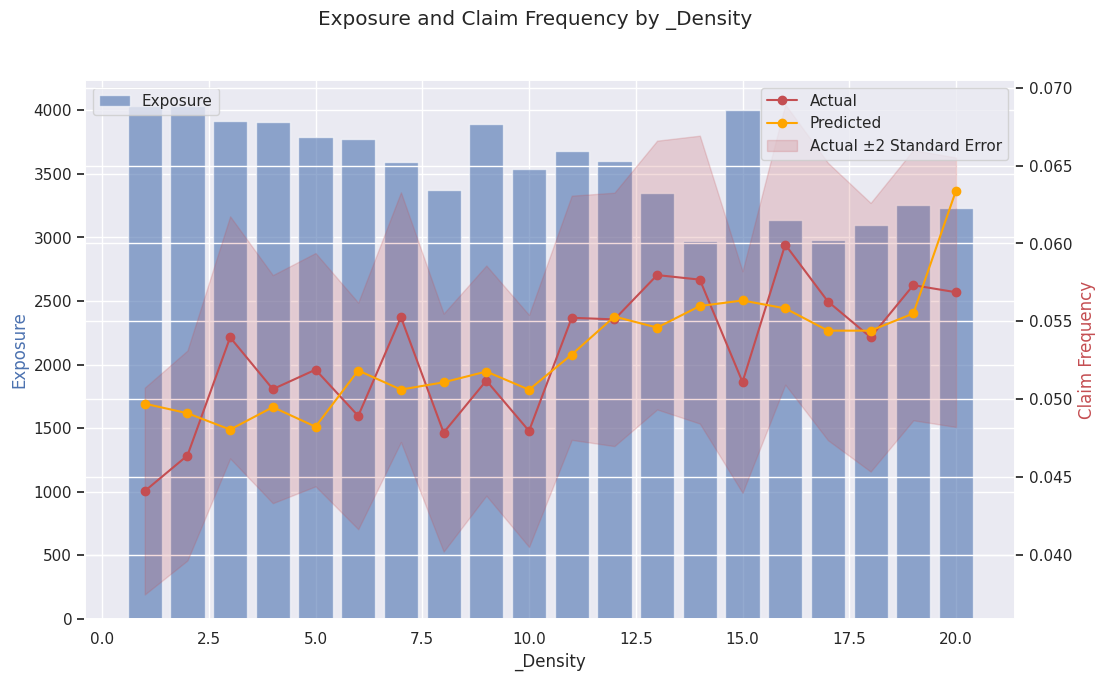

In [59]:
plotave(test, features, 'Exposure', 'ClaimNb', 'fitGLM2')

Vehicle Brand was excluded from to model due to lack of explanation power

The model was indeed predictive for brands without including it
For our analysis we measure the cross-subsidy via the available explanatory variables actual vs predicted squared error.

Let's see the RoC curves. 1 is have one or more claims, 0 is no claim. First for the learning set, after the testing set

In [60]:
from sklearn.metrics import roc_curve, auc
learn['RoC']=np.where(learn['ClaimNb']==0,0,1)
fpr_learn, tpr_learn, _ = roc_curve(learn['RoC'], learn['fitGLM2'])
roc_auc_learn = auc(fpr_learn, tpr_learn)
fpr_test, tpr_test, _ = roc_curve(test['RoC'], test['fitGLM2'])
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_learn, tpr_learn, color='blue', lw=2, label='Learn ROC curve (area = %0.2f)' % roc_auc_learn)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)', linestyle='--' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

KeyError: 'RoC'

In [ ]:
from scipy import stats

# Initialize a list to store the results
xsubtmp = []

# Loop over each feature
#for col in ('VehBrand', 'VehPower', 'VehAge', 'BonusMalus', 'Area', 'Region', 'VehGas', 'DrivAge', 'Density'):
#Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
for col in features:
    # Aggregate statistics for each feature
    aggregated = learn.groupby(col).agg(
        W=('Exposure', 'sum'),
        V=('ClaimNb', 'mean'),
        P=('fitGLM2', 'mean'),
        SumA=('ClaimNb', 'sum'),
        SumP=('fitGLM2', 'sum'),
        Std=('ClaimNb', 'std')
    ).reset_index()
    
    # Calculate the p-value for the current feature
    p_values = []
    for feature_value in aggregated[col].unique():
        subset = learn[learn[col] == feature_value]
        if len(subset) > 1:  # Check to ensure there are enough samples to perform the train
            t_stat, p_value = stats.ttest_ind(subset['ClaimNb'], subset['fitGLM2'], equal_var=False)
            p_values.append(p_value)
        else:
            # If not enough samples, set p-value to NaN
            p_values.append(float('nan'))
    
    # Add p-values to the aggregated DataFrame
    aggregated['p_value'] = p_values
    
    # Append the result to the list
    xsubtmp.append(aggregated)

# Concatenate all results into a single DataFrame
xsub = pd.concat(xsubtmp, ignore_index=True)

# Display the resulting DataFrame
print(xsub)

In [ ]:
#xsub['SE']=xsub['Std']/np.sqrt(xsub['W'])
#xsub['asE']=abs(xsub['P']-xsub['V'])/xsub['Std']
#xsub['was']=xsub['asE']*xsub['W']
#xsub['sE']=   (xsub['P']-xsub['V'])/xsub['p_value']
#xsub['aE']=abs(xsub['P']-xsub['V'])/xsub['p_value']
#xsub['S']=np.where(xsub['P']>xsub['V'],1,0)
#sum((xsub['V']-xsub['P'])**2*xsub['W'])#original fit=70.66224441811525
#sum(abs(xsub['P']-xsub['V'])*xsub['W'])#original fit=2500.3531781474117
#sum(xsub['was'])#original fit=5058.925080894959
#sum(xsub['apE'])#original fit=301.3702139355771 oops, learn should be used intead of train 
#sum(xsub['apE'])#binned fit=472.33569653952935
#sum(xsub['apE'])#binned fit on learn=199.23088596423264 #oops p_value doesn't multiplies but divides
#sum(xsub['apE']*xsub['W'])#323170661006.11993
#xsub['SumE']=xsub['SumP']-xsub['SumA']
#sum(xsub['aE'])#85664981.64344479
#sum(xsub['SumAE'])#5209.829182928233
#xsub['SumE']=(xsub['P']-xsub['V'])/xsub['p_value']#85222585.5552867
#xsub['SumE']=1-1/(1+(xsub['P']-xsub['V'])/xsub['p_value'])
#xsub['pE']=(xsub['P']-xsub['V'])/xsub['p_value']
#xsub['SumAE']=abs(xsub['pe'])
#sum(xsub['SumAE'])#20.565982250965654
#xsub['sumE']=1-1/(1+xsub['SumAE'])
xsub['pE']=(xsub['P']-xsub['V'])/xsub['p_value']
xsub['SumE']=(1-1/(1+abs(xsub['pE'])))*np.sign(xsub['pE'])
sum(abs(xsub['pE']))#85222585.5552867

In [ ]:
# Create a histogram
plt.hist(xsub['SumE'], bins=40, edgecolor='black')

# Add titles and labels
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
xsub.sort_values(by='SumAE', ascending=False)

In [ ]:
if True:
    # Initialize the result DataFrame with test DataFrame
    step1 = df.copy()
    # Loop over the features and perform the join operations
    for feature in features:
        # Perform join
        step1 = pd.merge(step1, xsub[[feature, 'SumE']], on=feature, how='left', suffixes=('', ''))
        # Rename the spE column to avoid confusion
        step1.rename(columns={'SumE': f'SumE_{feature}'}, inplace=True)
    step1['ErrWeight'] = step1[[f'SumE_{feature}' for feature in features]].sum(axis=1)
    step1['ErrWAbs'] = abs(step1['ErrWeight'])
#    step1['ErrWeight'] /= step1['ErrWAbs'].mean()#for numeric stability after exponentiation
    step1['ErrRow']=step1['fitGLM2']-step1['ClaimNb']
    step1['Weight'] = np.exp(-np.sign(step1['ErrRow']*step1['ErrWeight'])*step1['ErrWAbs'])
#    step1['Weight'] =        -np.sign(step1['ErrRow']*step1['ErrWeight'])*step1['ErrWeight']
    step1

In [ ]:
# Create a histogram
plt.hist(step1['Weight'], bins=40, edgecolor='black')

# Add titles and labels
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
formula="Err ~ C(_VehPower) + C(_VehAge) + C(_BonusMalus) + C(_Area) + C(_Region) + VehGas + Density + DrivAge +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4)"
model2 = smf.glm(formula,freq_weights=step1['Weight'],family=sm.families.Gaussian(),data=step1)
w_glm2 = model2.fit(method='newton')
w_glm2.summary()

In [ ]:
learn["fitGLMw"] = w_glm2.predict(learn) * learn.Exposure
test["fitGLMw"] = w_glm2.predict(test) * test.Exposure

In [ ]:
learn["fitGLMw"].sum()

In [ ]:
abs(learn["fitGLMw"]).sum()

In [ ]:
sum(learn['ClaimNb'])

In [ ]:
plotave(test, features, 'Exposure', 'ClaimNb', 'fitGLM2', 'fitGLMw')